# GESTION DE PORTEFEUILLE - Assignement 1


#### Hugo Lamarre - HEC Montréal
#### Hiver 2023

### Etudiants

CARON Sébastien  - 11271997 

LEPEYTRE Vincent - 11237013

NONGUIERMA Harold - 11229979

TOURÉ Ousmane  -

In [1]:
import importlib
import numpy as np
import Functions as f
import Gurobi as g
importlib.reload(f)
importlib.reload(g)

import numpy as np
import pandas as pd
from scipy import optimize
import scipy.optimize as sco



#### Data Importation

In [2]:
path_data = "48_Industry_Portfolios.csv"
path_rf = "SOFR30DAYAVG.xls"
path_regression ="iShares MSCI USA Factor ETF bis1.xlsx"

In [3]:
### Industries selected : 

Data_select1_names = ['Mines','Guns','Hshld','Oil','Txtls']

Data_select2_names = ['Mines','Guns','Hshld','Oil','Txtls','Agric', 'Util', 'Chems', 'Drugs', 'Telcm']

In [4]:
### Monthly data on 48 Industry Portfolios from Ken French’s website

Data = f.Load_ind_data(path_data)["Data"]
Data = Data[Data.index >= '2000-01'] # We keep only the data after 2000

Data_select = Data[Data_select1_names]

Industrie_selected = Data_select.columns


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda x: pd.datetime.strptime(x,'%Y%m')


In [5]:
### Risk free asset : 30-Day Average SOFR, Percent, Daily, Not Seasonally Adjusted

Expected_Risk_free = f.Load_rf(path_rf)/100


In [6]:
### Data for the determination of expected returns :

Variable_regression = f.Load_lasso_variable(path_regression)

## Determination of expected returns
### Multiple linear regression with regularization by lasso method :

#### 1/ Data set split betwen  train and test set : 

In [7]:
# Data use for the split : 

First_factor_obs = '2013-09-01'
Date_train = '2020-01-01' # Train set end
Date_test = '2021-06-01' # Test set beginning 
Last_date = '2022-12-01'

Variable_regression = Variable_regression[Variable_regression.index >= First_factor_obs]

Data_regression_lasso = f.Split_dataset(Data,Variable_regression,First_factor_obs,Date_train,Date_test,Last_date)

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])


#### 2/ Prediction : 

In [8]:
Resultat_prediction  = f.Lasso_regression(Data_regression_lasso)

#### 3/ Performance of  prediction : 

In [9]:
# R_squared moyen (Train set) :
Resultat_prediction.loc['R_squared_train'].median()

13.279726678521165

In [10]:
# R_squared moyen (Test set) :
Resultat_prediction.loc['R_squared_test'].median()

6.544141099740802

In [11]:
# MSE lasso prediction / MSE with naive historical mean :
Resultat_prediction.loc['ratio_mse'].median()

0.9204068953848257

#### 4/ Results : 

In [12]:
# Select only the prediction where the lasso approch perform better on the train set base on MSE ratio and R square

E_return_select = f.select_pred(Resultat_prediction,Data)

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


In [13]:
E_return = E_return_select[Data_select1_names]

## Determination of the covariance matrix :

In [14]:
## Covariance matrix for selection 1 of industries : 

E_cov_1 = f.Ledoit_wolf(Data[Data_select1_names])

E_cov_2 = f.Ledoit_wolf(Data[Data_select2_names])

## Question 1
### (a) Graph the mean-variance frontier without risk-free asset of the selected 5 industry portfolios.
Display each industry portfolio in the chart.

#### Estimation of the covariance-matrix and expected return   :

In [15]:
# Expected return : other possible approach simple machine learning with technical indicator 
#E_return = g.annualize_rets(Data_select/100, 12)  #On a besoin des rendement annualisées comme le risk free rate est annualisé 
#E_cov = Data_select.cov() # Just for test
Nbr_PTF = 100
K = 5 #On veut 5 Assets

##### Determination of the optimal  portfolio  for a given return (with Short Sell) :

Restricted license - for non-production use only - expires 2024-10-28


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

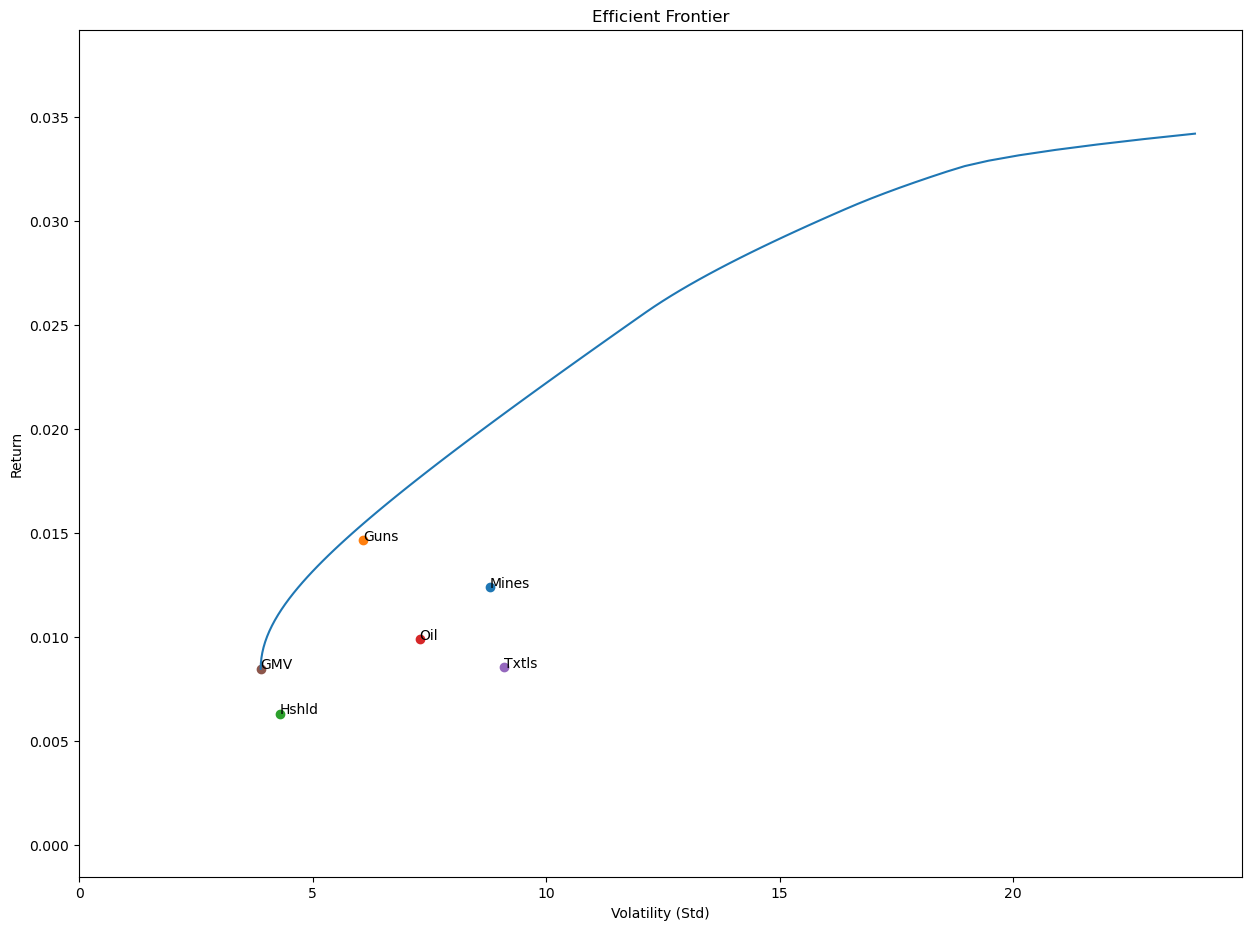

In [16]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K, Nbr_PTF, bounds = (-2,2), show_cml=False, show_gmv=True)

### (b) Graph the mean-variance frontier with risk-free asset of the selected 5 industry portfolios. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the introduction of a risk-free asset.



<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

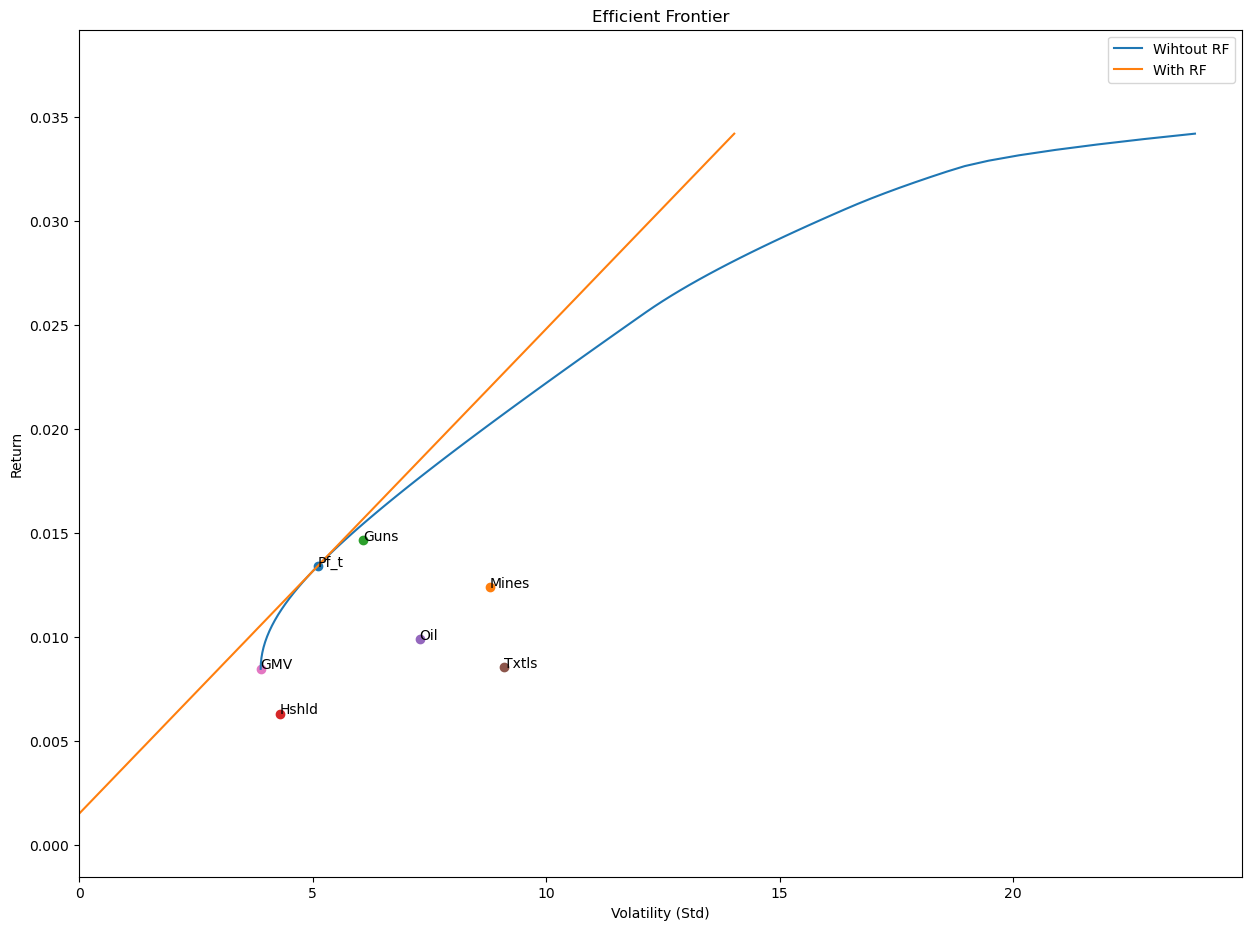

In [17]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K , Nbr_PTF, bounds = (-2,2), show_cml=True, show_gmv=True)

In [18]:
g.Ptf_target_optimization_W_Rf_Gurobi(E_return, E_cov_1, Expected_Risk_free, K , Nbr_PTF, bounds = (-2,2))['Efficient_frontiere_weigth']

Risk_free   Mines    Guns   Hshld     Oil   Txtls
0      1.0000 -0.0000  0.0000 -0.0000 -0.0000  0.0000
1      0.9720  0.0053  0.0202  0.0054  0.0014 -0.0043
2      0.9440  0.0107  0.0403  0.0108  0.0028 -0.0086
3      0.9159  0.0160  0.0605  0.0163  0.0042 -0.0129
4      0.8880  0.0214  0.0806  0.0217  0.0055 -0.0172
..        ...     ...     ...     ...     ...     ...
95    -1.6613  0.5077  1.9154  0.5150  0.1315 -0.4083
96    -1.6892  0.5130  1.9355  0.5204  0.1329 -0.4126
97    -1.7173  0.5184  1.9557  0.5258  0.1343 -0.4169
98    -1.7453  0.5237  1.9759  0.5312  0.1357 -0.4212
99    -1.7732  0.5291  1.9960  0.5366  0.1370 -0.4255

[100 rows x 6 columns]

#### Explanations: 

### (c) Describe the tangent portfolio and its characteristics such as its mean and variance and the weights of each asset


In [19]:
result = g.tangent_Gurobi(E_return, E_cov_1, Expected_Risk_free, K , Nbr_PTF = 100, bounds= (-2,2))
result


Mines    Guns   Hshld     Oil   Txtls    Return  Volatility    Sharpe
19  0.1951  0.7313  0.1815  0.0472 -0.1552  0.013401    5.106317  0.002332

### (d) Graph the mean-variance frontier without risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.



<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

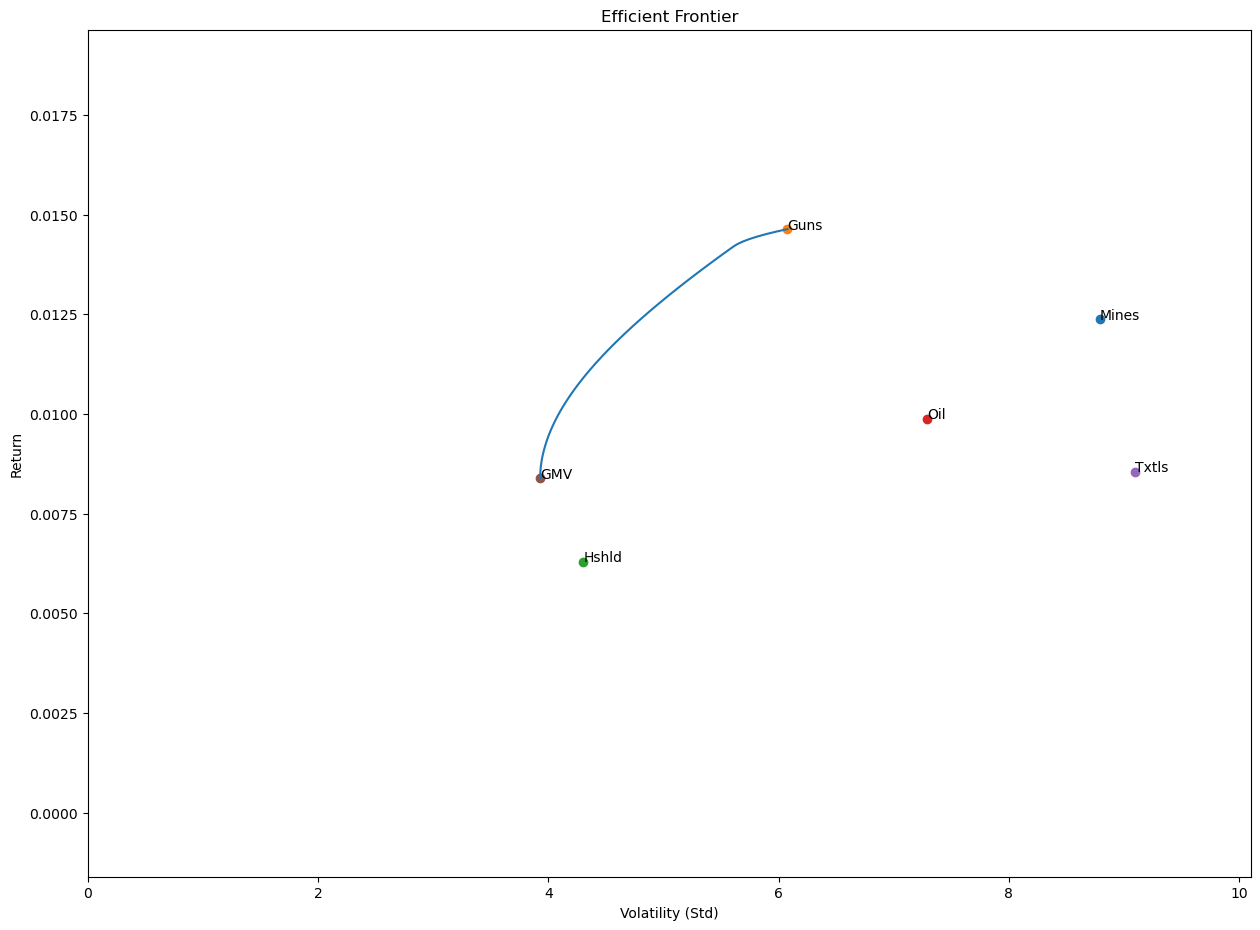

In [20]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K , Nbr_PTF, bounds = (0, 1), show_cml=False, show_gmv=True)

#### Explain how the mean-variance frontier has changed with the constraint: (To continue)

### (e) Graph the mean-variance frontier with risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

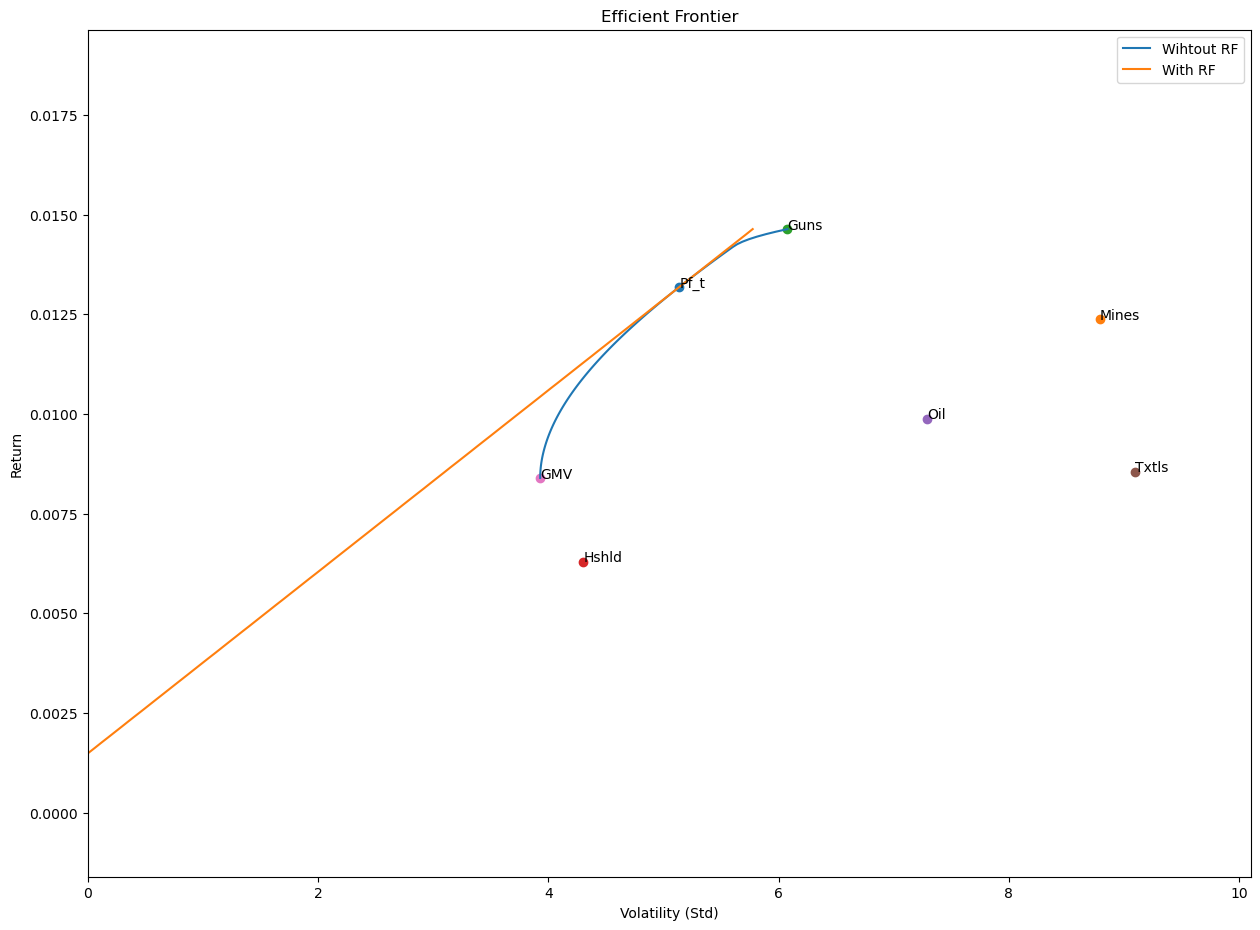

In [21]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K , Nbr_PTF, bounds = (0, 1), show_cml=True, show_gmv=True)

#### Explain how the mean-variance frontier has changed with the constraint:

(To Continue)

### (f) Can you find a tangent portfolio under short-sale constraints? If so, describe its characteristics such as its mean and variance and the weights of each asset. Explain how the tangent portfolio has changed with the constraint

In [22]:
result = g.tangent_Gurobi(E_return, E_cov_1, Expected_Risk_free, K , Nbr_PTF = 100, bounds= (0,1))
result



Mines    Guns   Hshld     Oil  Txtls    Return  Volatility    Sharpe
76  0.152  0.7028  0.1161  0.0291    0.0  0.013186    5.137534  0.002276

Explain:

### (g) Repeat the same calculations in (a)-(f) adding 5 other industry portfolios to the original list of 5 industry portfolios you chose at the start. Compare the results and discuss the advantages and disadvantages of using 10 portfolios instead of 5.

In [23]:
#On pourrait randomnize le sampling

Data_select2 = Data[Data_select2_names]

#E_return_M_2 =Resultat_prediction[Data_select2_names].loc['E_R'].T

E_return_2 = E_return_select[Data_select2_names]
#E_return_2 = f.annualize_rets_prediction(E_return_M_2, 12)

# Expected return : other possible approach simple machine learning with technical indicator 
#E_return = g.annualize_rets(Data_select2/100, 12)  #On a besoin des rendement annualisées comme le risk free rate est annualisé 
#E_cov = Data_select2.cov() # Just for test
Nbr_PTF = 100
K = 10

#### g-(a) Graph the mean-variance frontier without risk-free asset of the selected 10 industry portfolios.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

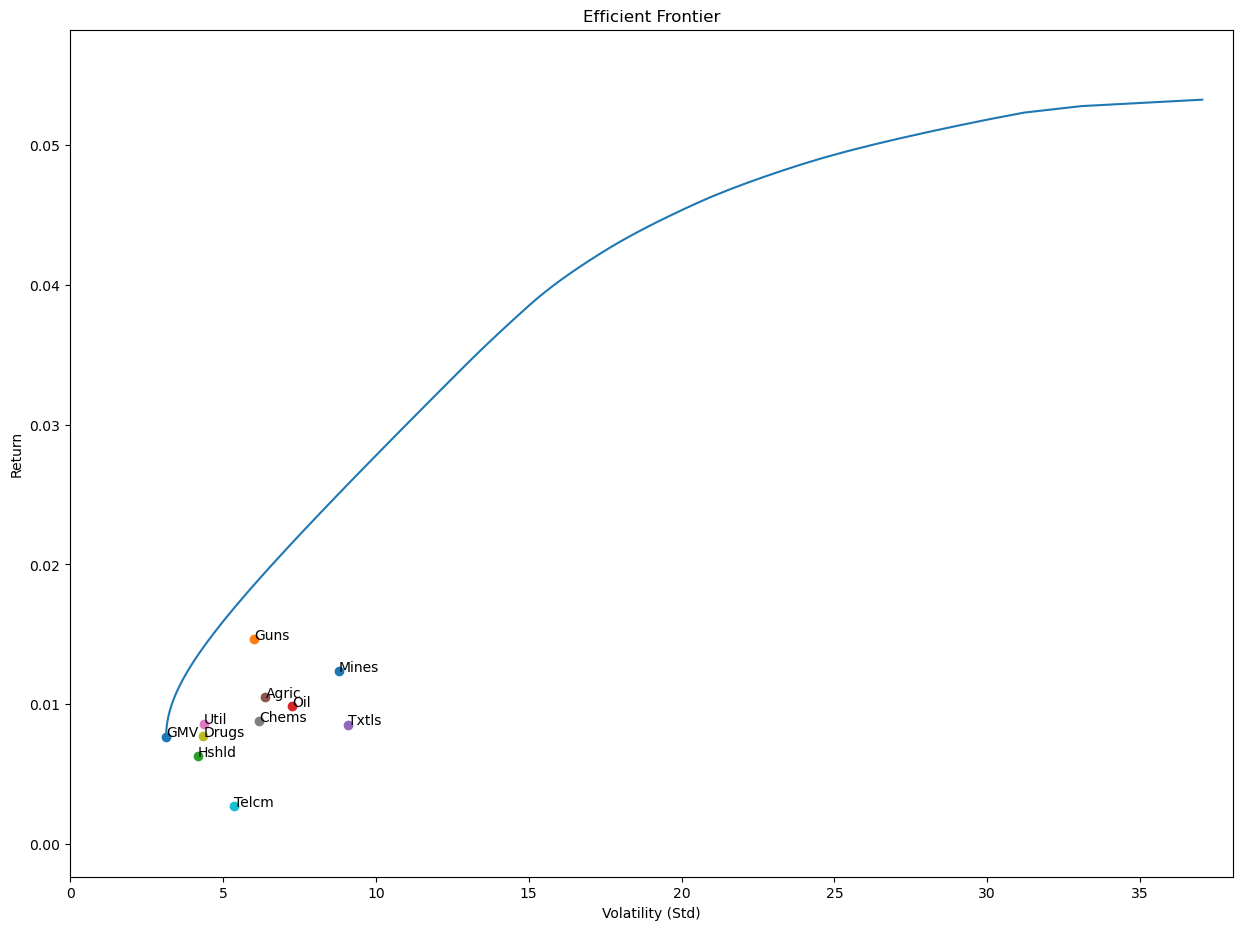

In [24]:
g.plot_ef_Gurobi(E_return_2, E_cov_2, Expected_Risk_free, K, Nbr_PTF, bounds = (-2,2), show_cml=False, show_gmv=True)

#### g-(b) Graph the mean-variance frontier with risk-free asset of the selected 10 industry portfolios. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the introduction of a risk-free asset.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

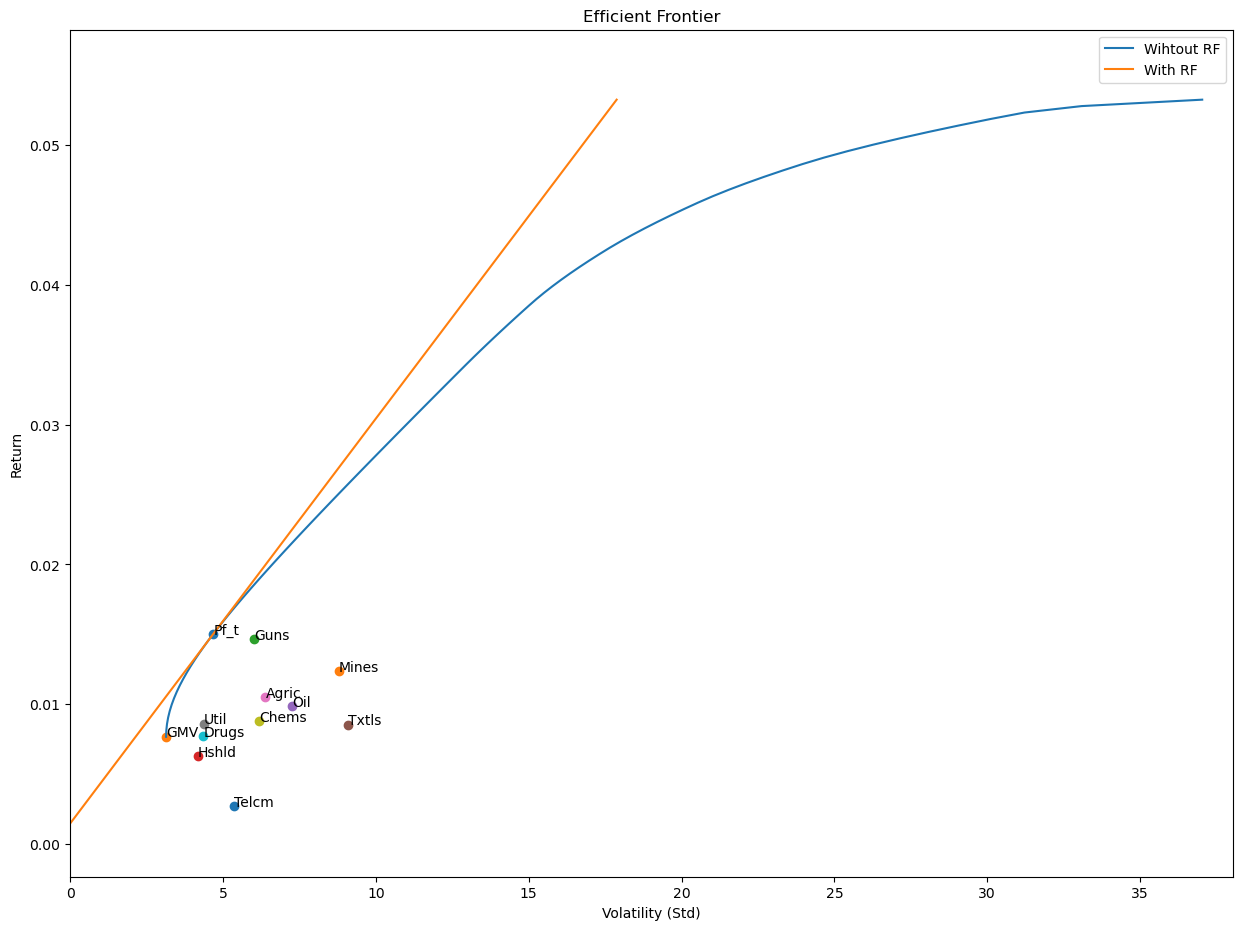

In [25]:
g.plot_ef_Gurobi(E_return_2, E_cov_2, Expected_Risk_free, K, Nbr_PTF, bounds = (-2,2), show_cml=True, show_gmv=True)

#### g-(c) Describe the tangent portfolio and its characteristics such as its mean and variance and the weights of each asset

In [26]:
result = g.tangent_Gurobi(E_return_2, E_cov_2, Expected_Risk_free, K , Nbr_PTF, bounds= (-2,2))

result

Mines    Guns   Hshld     Oil   Txtls   Agric    Util   Chems   Drugs  \
16  0.1667  0.5169  0.0291 -0.0276 -0.0446  0.2252  0.3468 -0.1459  0.3979   

     Telcm    Return  Volatility    Sharpe  
16 -0.4644  0.015038    4.680815  0.002894

#### g-(d) Graph the mean-variance frontier without risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

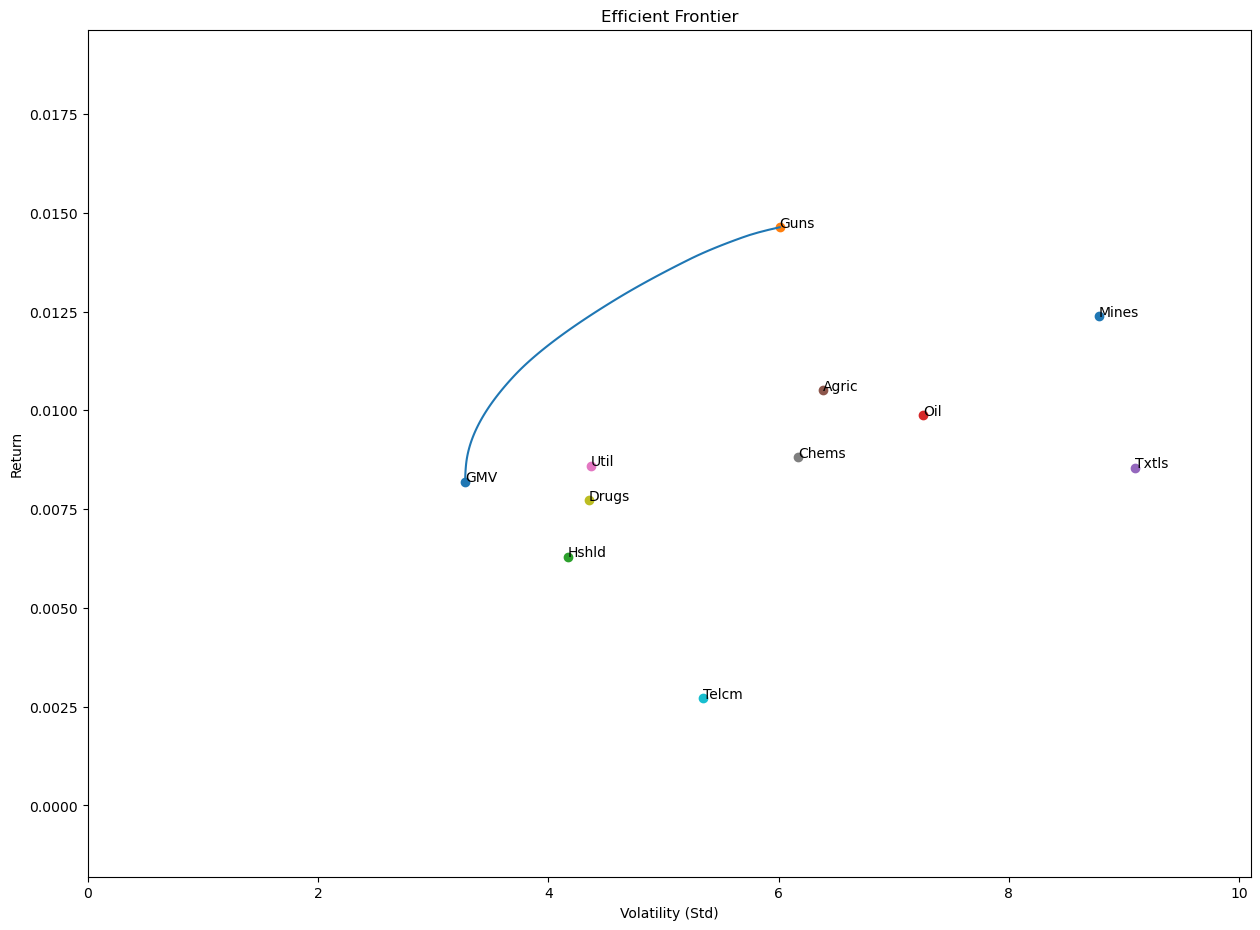

In [27]:
g.plot_ef_Gurobi(E_return_2, E_cov_2, Expected_Risk_free, K, Nbr_PTF, bounds = (0,1), show_cml=False, show_gmv=True)

#### g-(e) Graph the mean-variance frontier with risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

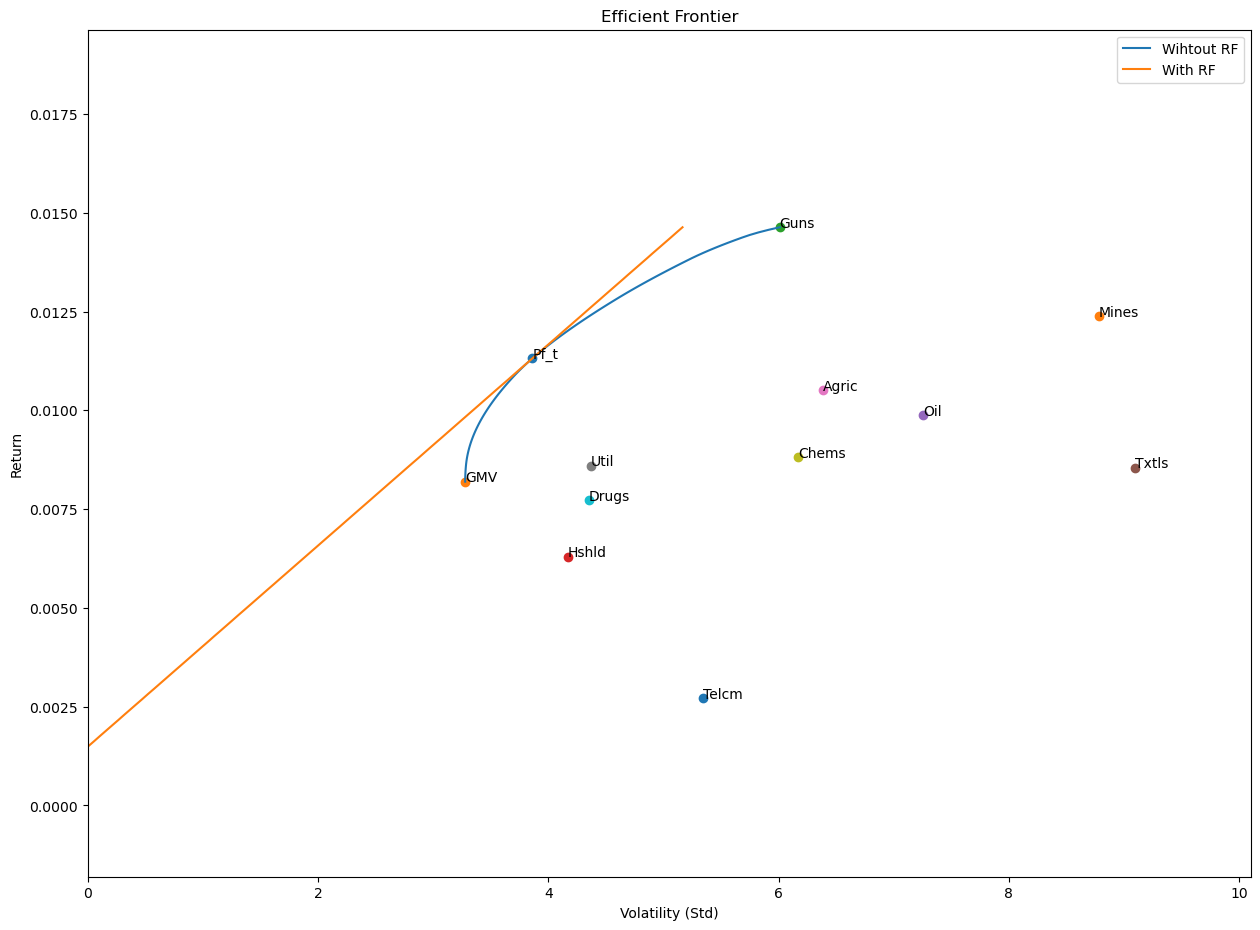

In [28]:
g.plot_ef_Gurobi(E_return_2, E_cov_2, Expected_Risk_free, K, Nbr_PTF, bounds = (0,1), show_cml=True, show_gmv=True)

#### g-(f) Can you find a tangent portfolio under short-sale constraints? If so, describe its characteristics such as its mean and variance and the weights of each asset. Explain how the tangent portfolio has changed with the constraint

In [29]:
result = g.tangent_Gurobi(E_return_2, E_cov_2, Expected_Risk_free, K , Nbr_PTF, bounds= (0,1))

result

Mines    Guns  Hshld  Oil  Txtls   Agric    Util  Chems  Drugs  Telcm  \
48  0.0021  0.4242    0.0  0.0    0.0  0.1514  0.2603    0.0  0.162    0.0   

      Return  Volatility    Sharpe  
48  0.011318    3.861954  0.002544

### (h) The investment policy statement now limits you to invest in up to 3 industry portfolios from the original list of 5 industry portfolios. Repeat the same calculations in (a)-(f) with this additional constraint on the maximum number of assets. Is the optimal combination of assets the same for every target expected return?

In [30]:
#Est-ce qu'on fait une contrainte dans l'optimisateur?
#On peut prendre les 3 maximum weight in abs(value)

#E_cov = Data_select.cov() # Just for test
Nbr_PTF = 100
K=3

#### h-(a) Graph the mean-variance frontier without risk-free asset of the selected 3 industry portfolios. vs 5


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

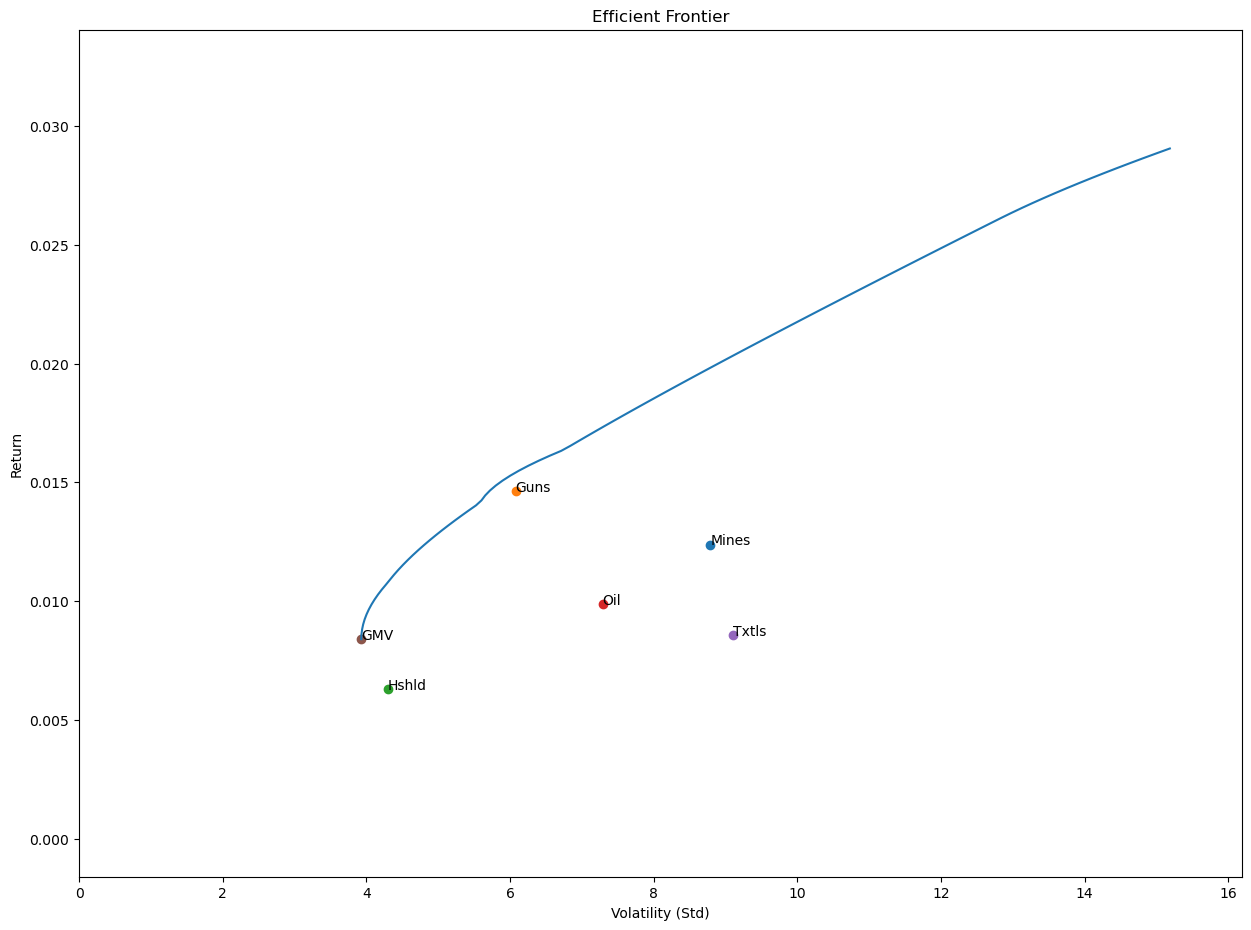

In [31]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K, Nbr_PTF, bounds = (-2,2), show_cml=False, show_gmv=True)



#### h-(b) Graph the mean-variance frontier with risk-free asset of the selected 3 industry portfolios. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the introduction of a risk-free asset.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

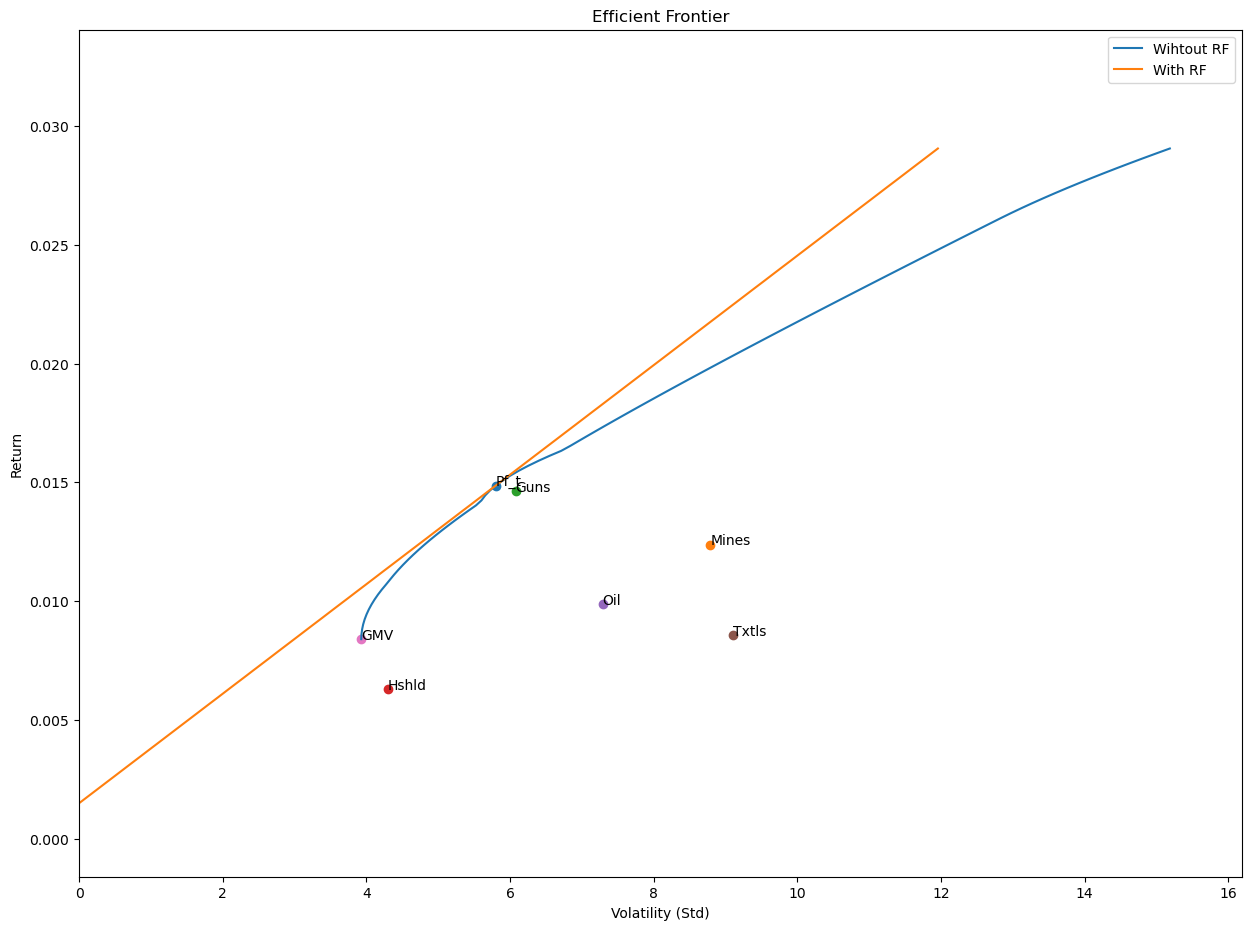

In [32]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K, Nbr_PTF, bounds = (-2,2), show_cml=True, show_gmv=True)

#### h-(c) Describe the tangent portfolio and its characteristics such as its mean and variance and the weights of each asset

In [33]:
#Trouver portefeuille maximum sharp ratio (Regler probleme de la fonction ou expliquer)
result = g.tangent_Gurobi(E_return, E_cov_1, Expected_Risk_free, K, Nbr_PTF, bounds= (-2,2))
result


Mines    Guns  Hshld  Oil   Txtls    Return  Volatility    Sharpe
31  0.2606  0.8738    0.0  0.0 -0.1344  0.014865    5.801584  0.002305

#### h-(d) Graph the mean-variance frontier without risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

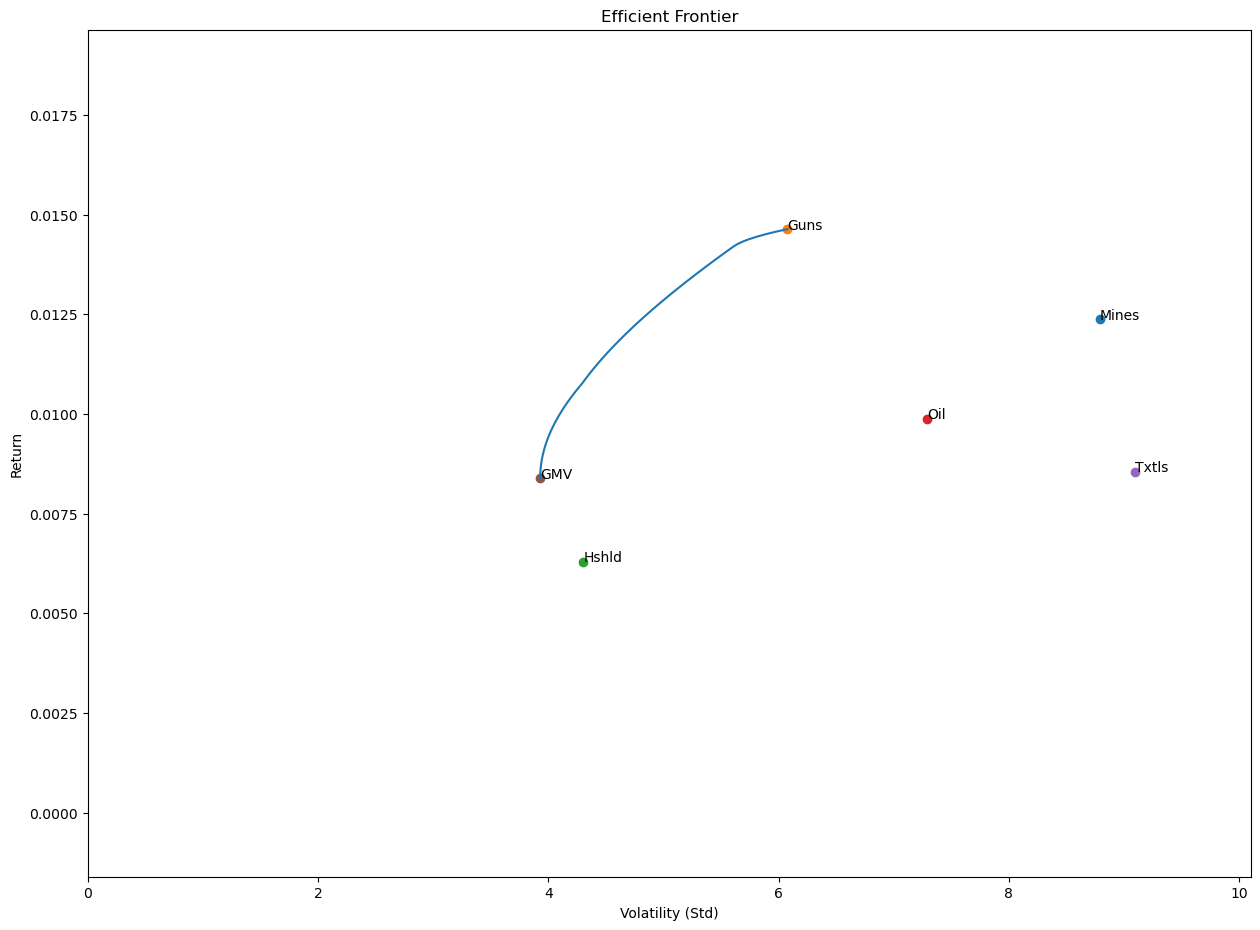

In [34]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K, Nbr_PTF, bounds = (0,1), show_cml=False, show_gmv=True)

#### h-(e) Graph the mean-variance frontier with risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

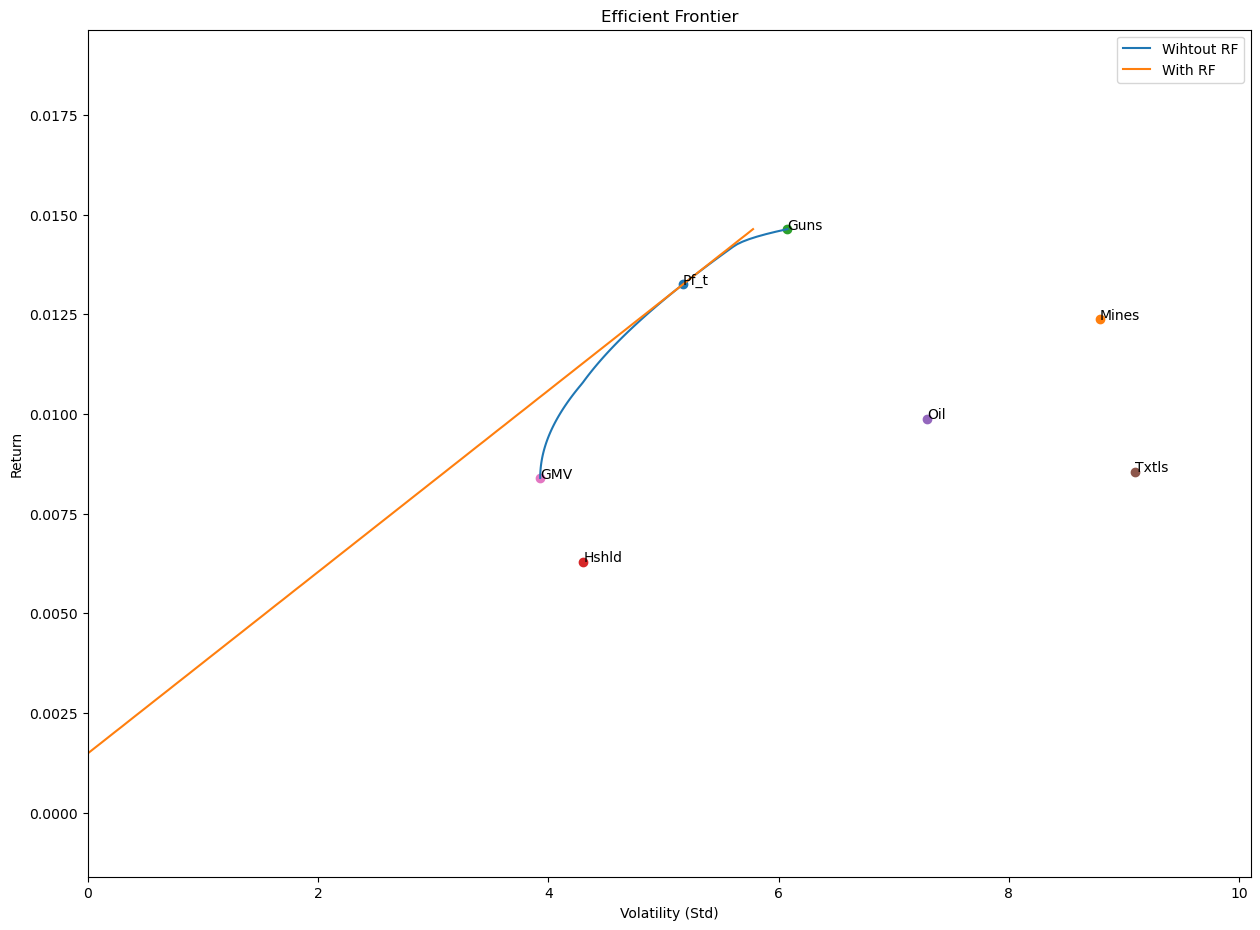

In [35]:
g.plot_ef_Gurobi(E_return, E_cov_1, Expected_Risk_free, K, Nbr_PTF, bounds = (0,1), show_cml=True, show_gmv=True)

#### h-(f) Can you find a tangent portfolio under short-sale constraints? If so, describe its characteristics such as its mean and variance and the weights of each asset. Explain how the tangent portfolio has changed with the constraint

In [36]:
#Trouver portefeuille maximum sharp ratio
result = g.tangent_Gurobi(E_return, E_cov_1, Expected_Risk_free, K, Nbr_PTF, bounds= (0,1))
result


Mines    Guns   Hshld  Oil  Txtls    Return  Volatility    Sharpe
77  0.1652  0.7132  0.1216  0.0    0.0  0.013249     5.16798  0.002275

## Question 2

### (a) Implement the portfolio resampling approach to demonstrate the effect of estimation uncertainty on the mean-variance frontier and tangent portfolios computed in Question 1.

### (a-1) Graph the mean-variance frontier without risk-free asset of the selected 5 industry portfolios.¶Display each industry portfolio in the chart.

In [37]:
Nsim=1000
Nbr_PTF = 100
K = 5 #On veut 5 Assets
Resample1=g.boostrap(Data_select,Nsim)#On genere nos simulation par Bootstraap

In [38]:
result1=g.resample_no_risk(E_return, E_cov_1,Resample1, K, Nbr_PTF,path_regression, bounds = (-2,2))
result2=g.resample_with_risk(E_return, E_cov_1,Resample1,Expected_Risk_free,K, Nbr_PTF,path_regression, bounds = (-2,2))

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

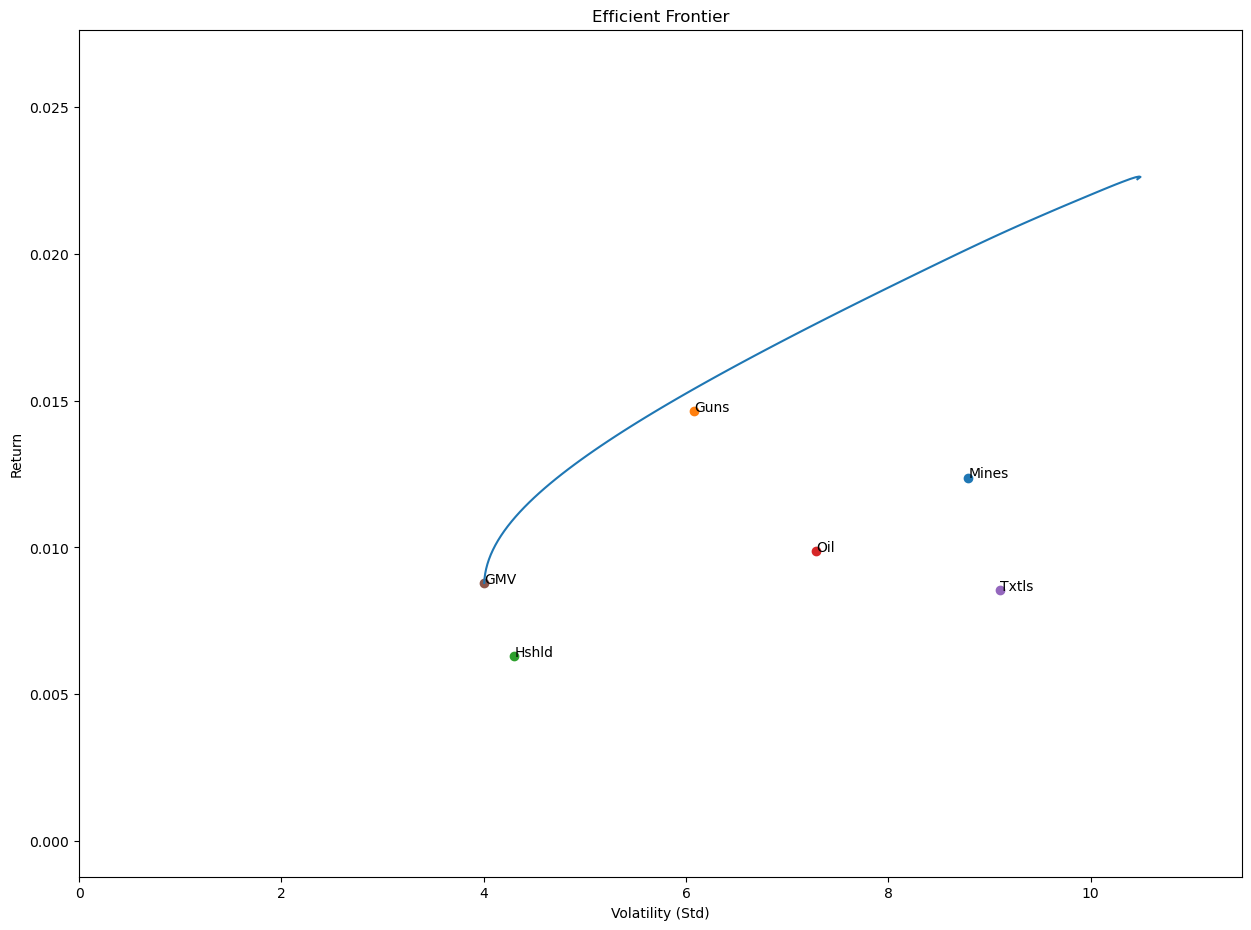

In [39]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=False, show_gmv=True)

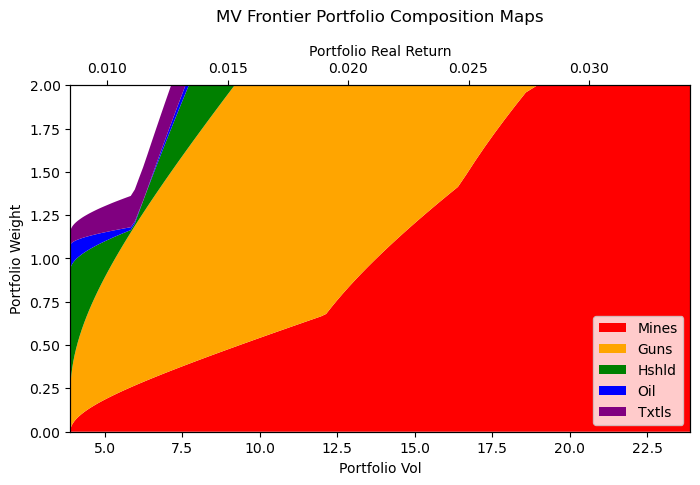

In [40]:
g.transition_map(E_return, E_cov_1,Expected_Risk_free, K, Nbr_PTF,bounds = (-2,2),no_risk=True)

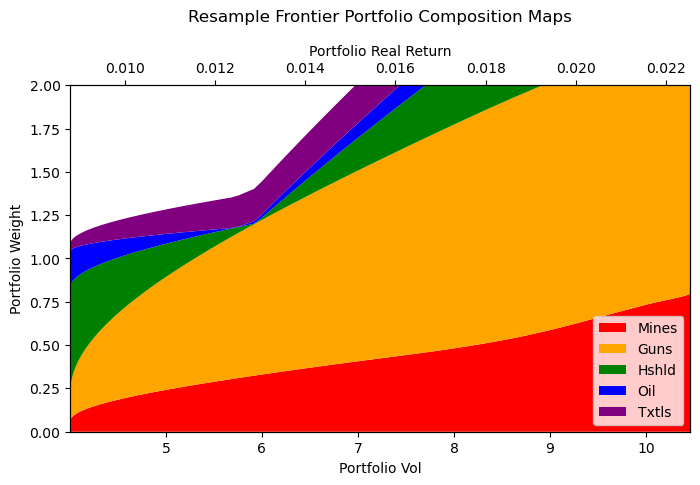

In [41]:
g.Resample_transition_map(result1,bounds = (-2,2))

### (a-1-b) Graph the mean-variance frontier with risk-free asset of the selected 5 industry portfolios. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the introduction of a risk-free asset.¶

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

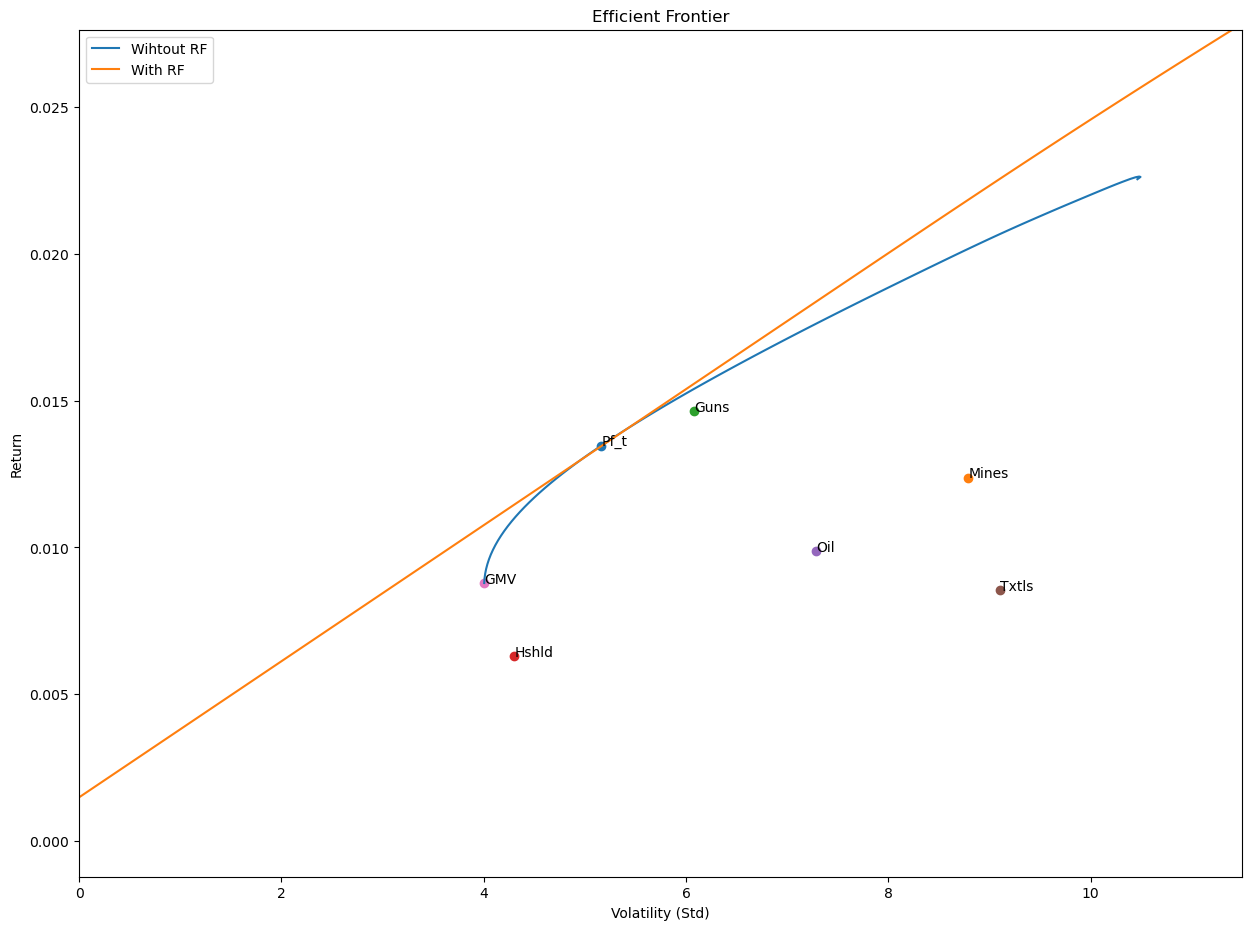

In [42]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=True, show_gmv=True)

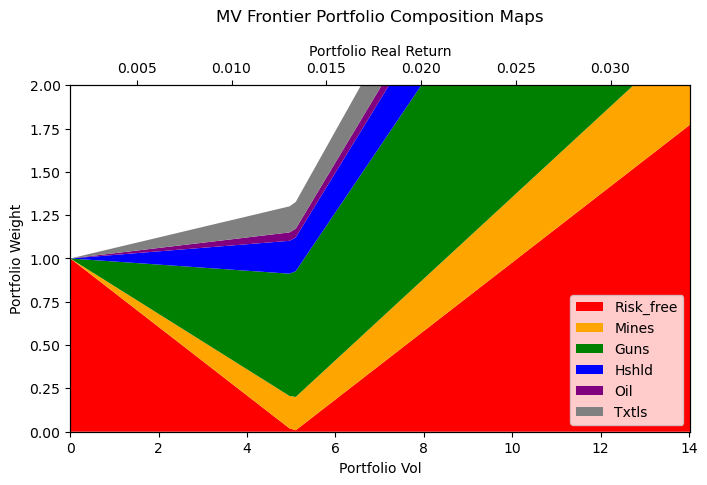

In [43]:
g.transition_map(E_return, E_cov_1,Expected_Risk_free, K, Nbr_PTF,bounds = (-2,2),no_risk=False)

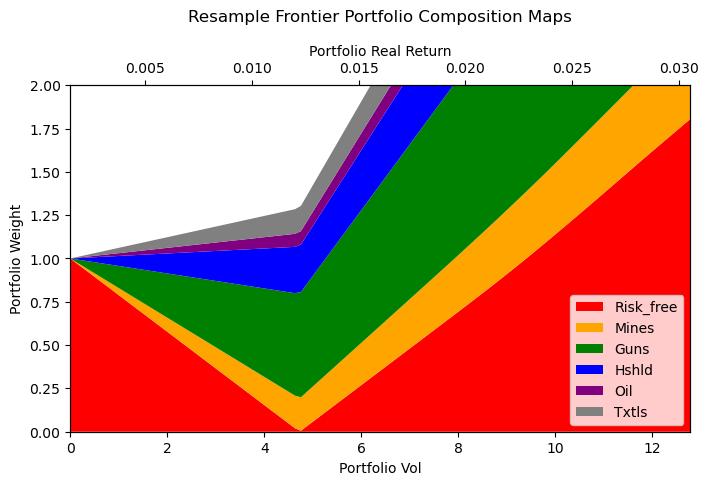

In [44]:
g.Resample_transition_map(result2, bounds = (-2,2))

### (a-1-c) Describe the tangent portfolio and its characteristics such as its mean and variance and the weights of each asset(a-1-c) Describe the tangent portfolio and its characteristics such as its mean and variance and the weights of each asset

In [45]:
result = g.tangent_resample(result1,Expected_Risk_free)
result


Mines      Guns     Hshld       Oil     Txtls    Return  Volatility  \
29  0.257244  0.694501  0.155297  0.043131 -0.150176  0.013468    5.161686   

     Sharpe  
29  0.00232

### (a-1-d) Graph the mean-variance frontier without risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.

In [46]:
result1=g.resample_no_risk(E_return, E_cov_1,Resample1, K, Nbr_PTF,path_regression, bounds = (0,1))
result2=g.resample_with_risk(E_return, E_cov_1,Resample1,Expected_Risk_free,K, Nbr_PTF,path_regression, bounds = (0,1))

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

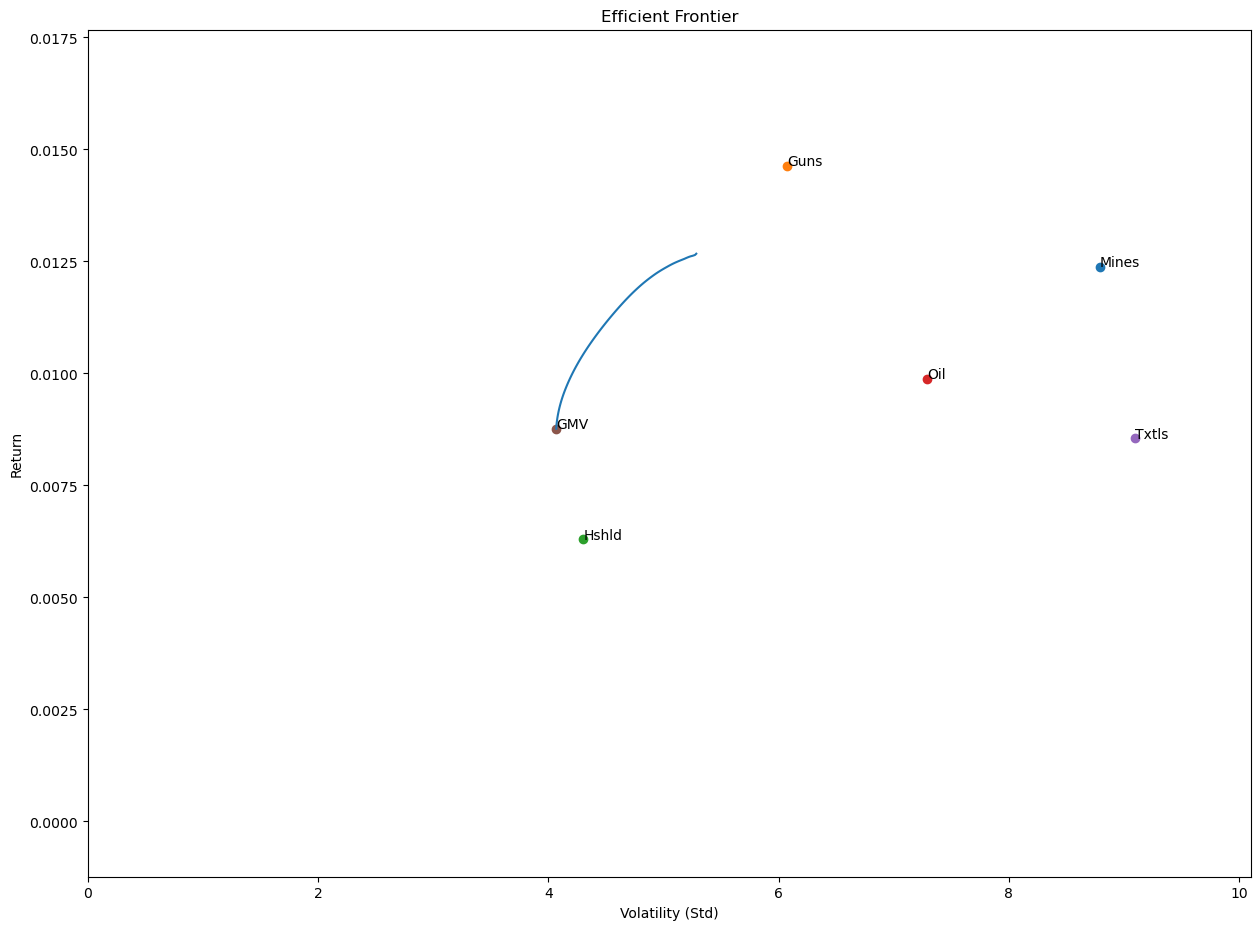

In [47]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=False, show_gmv=True)

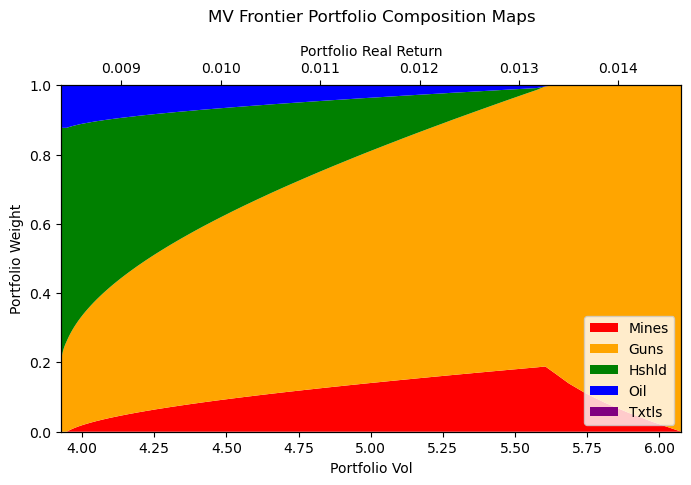

In [48]:
g.transition_map(E_return, E_cov_1,Expected_Risk_free, K, Nbr_PTF,bounds = (0,1),no_risk=True)

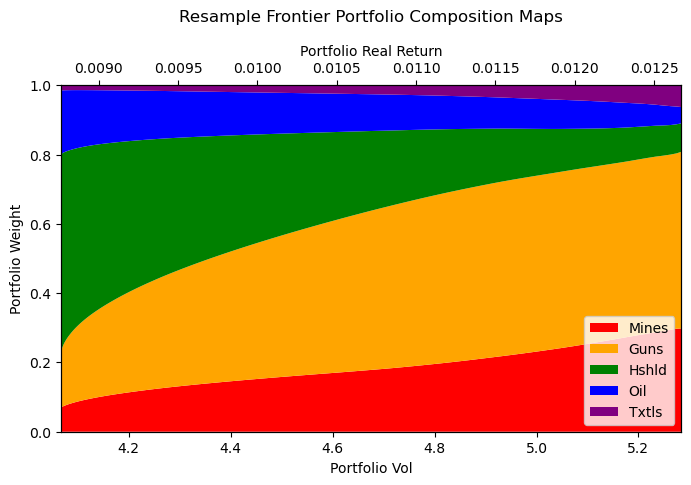

In [49]:
g.Resample_transition_map(result1, bounds = (0, 1))

### (a-1-e) Graph the mean-variance frontier with risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.¶

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

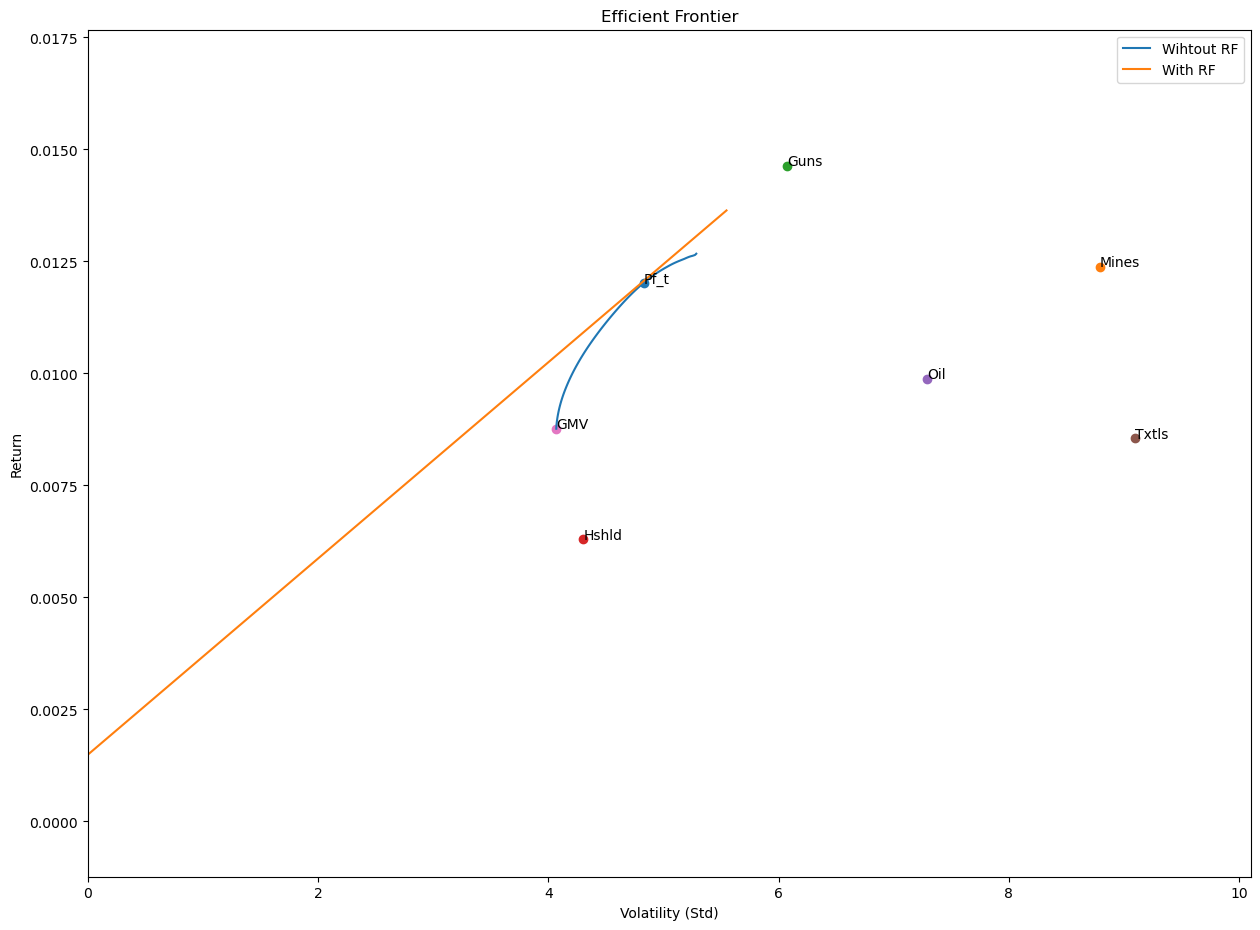

In [50]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=True, show_gmv=True)

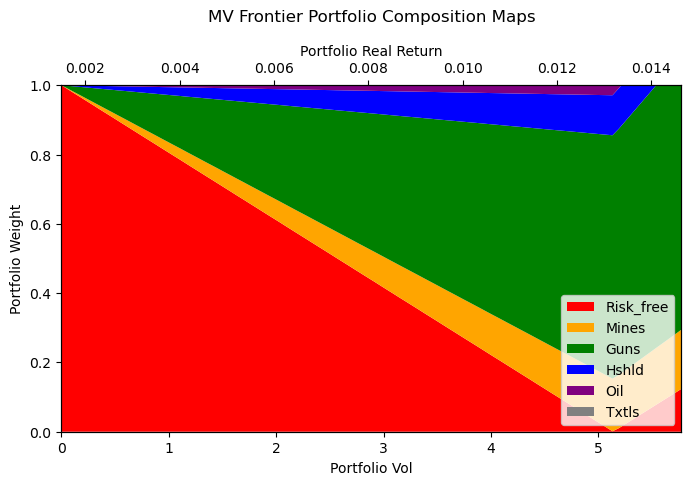

In [51]:
g.transition_map(E_return, E_cov_1,Expected_Risk_free, K, Nbr_PTF,bounds = (0,1),no_risk=False)

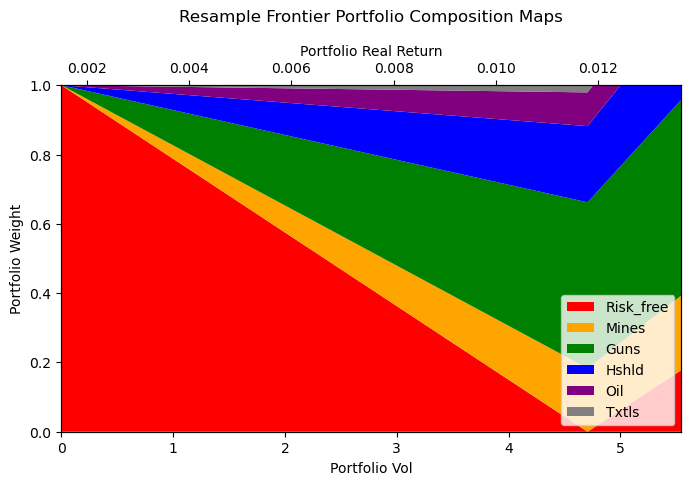

In [52]:
g.Resample_transition_map(result2, bounds = (0, 1))

### (a-1-f) Can you find a tangent portfolio under short-sale constraints? If so, describe its characteristics such as its mean and variance and the weights of each asset. Explain how the tangent portfolio has changed with the constraint¶


In [53]:
result = g.tangent_resample(result1,Expected_Risk_free)
result



Mines      Guns     Hshld       Oil     Txtls   Return  Volatility  \
73  0.19968  0.491188  0.182351  0.095964  0.030818  0.01202    4.826919   

      Sharpe  
73  0.002181

### (a-1-g) Repeat the same calculations in (a)-(f) adding 5 other industry portfolios to the original list of 5 industry portfolios you chose at the start. Compare the results and discuss the advantages and disadvantages of using 10 portfolios instead of 5.

In [54]:
K = 10
Resample2=g.boostrap(Data_select2,Nsim)#On genere nos simulation par Bootstraap

### a-1-g-(a) Graph the mean-variance frontier without risk-free asset of the selected 10 industry portfolios.

In [55]:
result1=g.resample_no_risk(E_return_2, E_cov_2,Resample2, K, Nbr_PTF,path_regression, bounds = (-2,2))
result2=g.resample_with_risk(E_return_2, E_cov_2,Resample2,Expected_Risk_free,K, Nbr_PTF,path_regression, bounds = (-2,2))

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

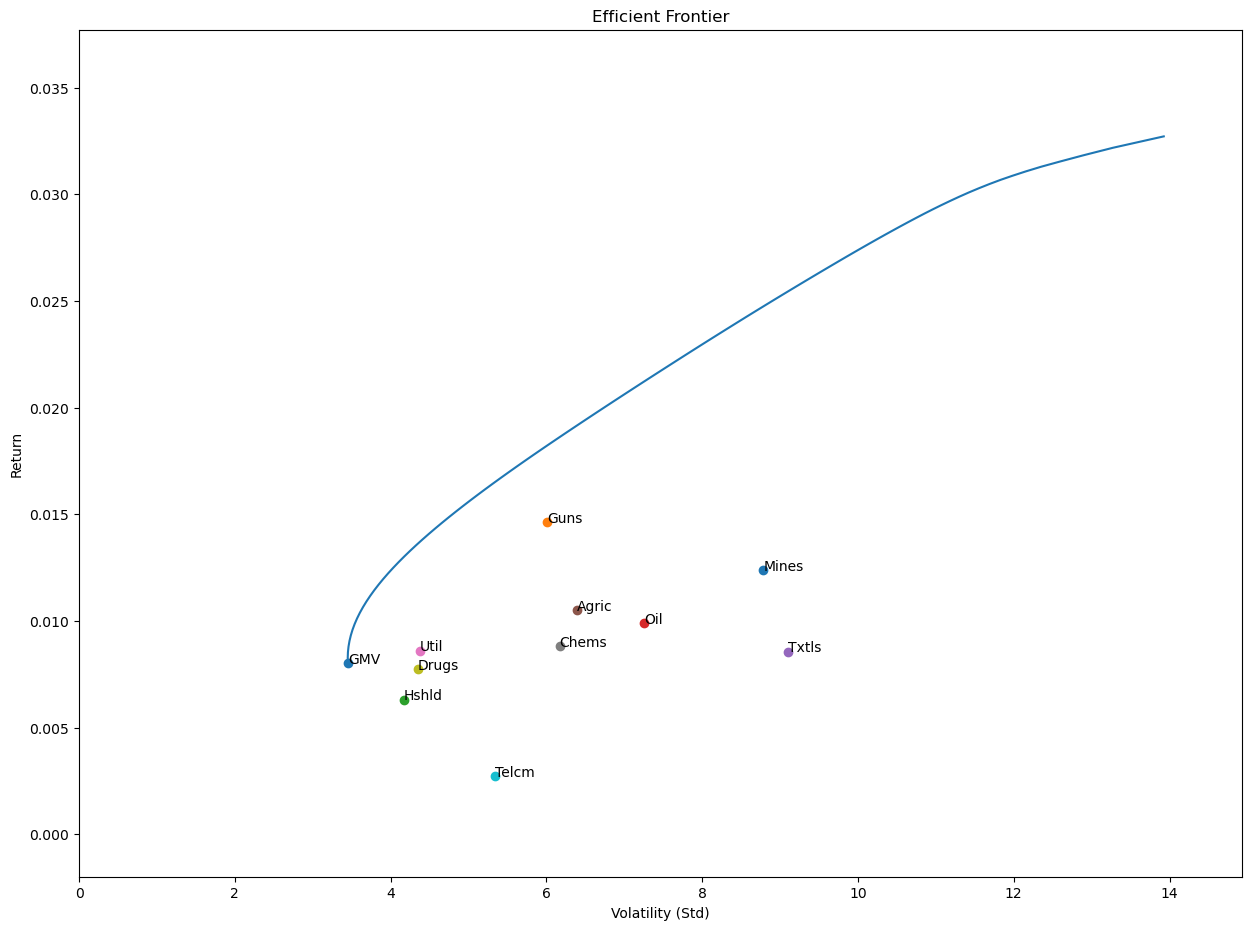

In [56]:
g.plot_Resample_ef_Gurobi(E_return_2, E_cov_2,result1,result2,Expected_Risk_free,show_cml=False, show_gmv=True)

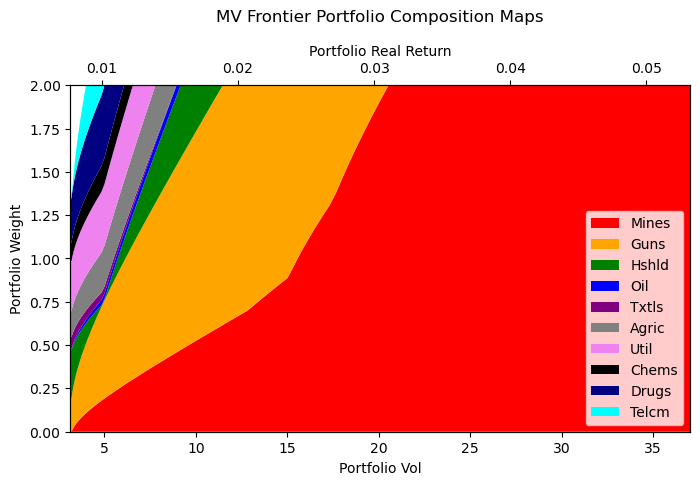

In [57]:
g.transition_map(E_return_2, E_cov_2,Expected_Risk_free, K, Nbr_PTF,bounds = (-2,2),no_risk=True)

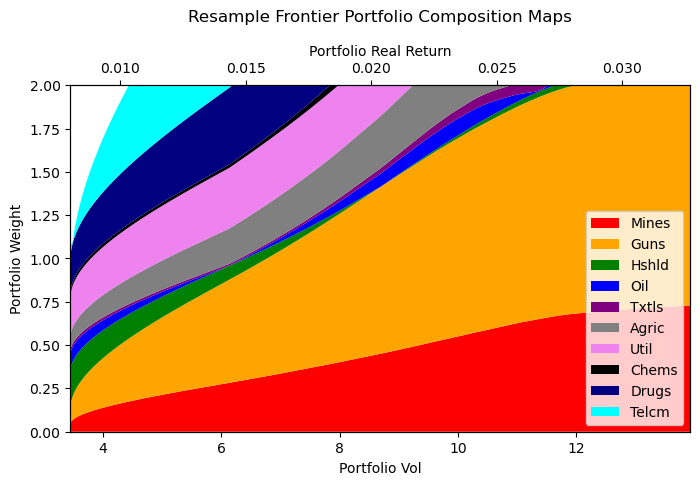

In [58]:
g.Resample_transition_map(result1,bounds = (-2,2))

### a-1-g-(b) Graph the mean-variance frontier with risk-free asset of the selected 10 industry portfolios. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the introduction of a risk-free asset.¶

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

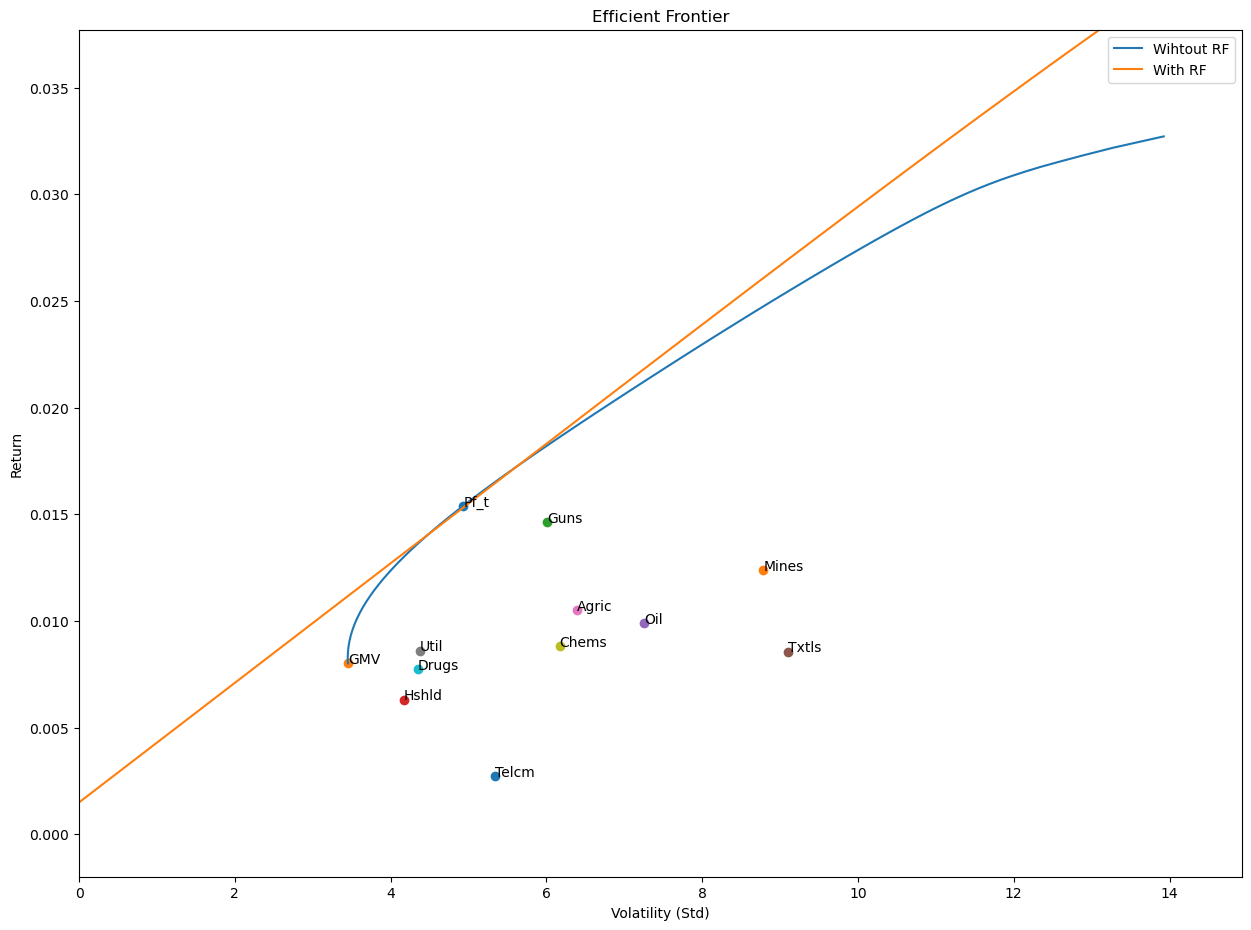

In [59]:
g.plot_Resample_ef_Gurobi(E_return_2, E_cov_2,result1,result2,Expected_Risk_free,show_cml=True, show_gmv=True)

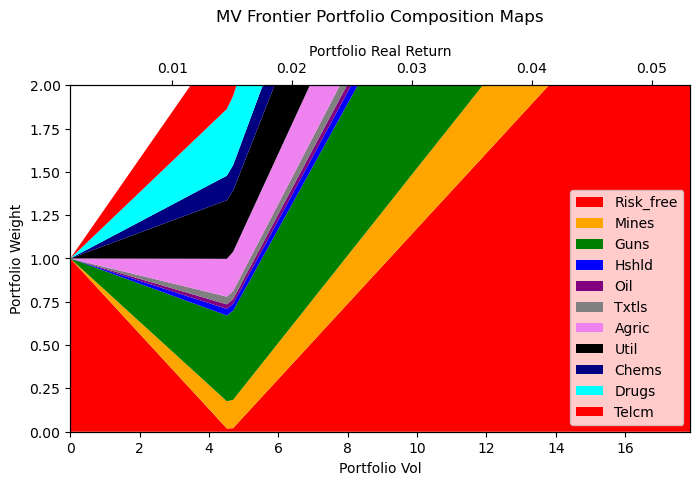

In [60]:
g.transition_map(E_return_2, E_cov_2,Expected_Risk_free, K, Nbr_PTF,bounds = (-2,2),no_risk=False)

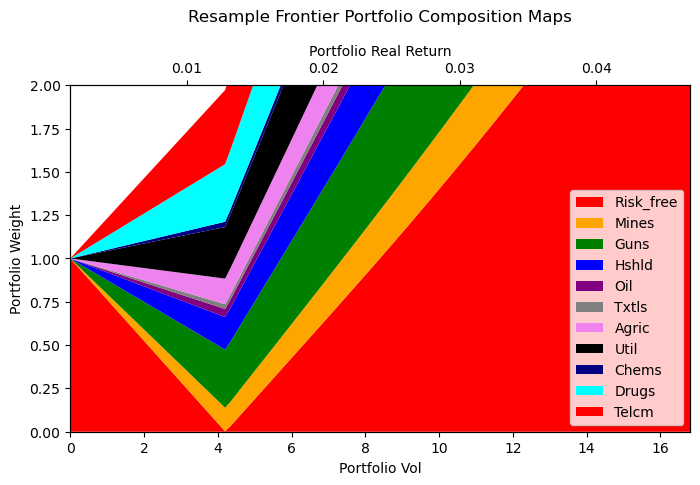

In [61]:
g.Resample_transition_map(result2, bounds = (-2,2))

### a-1-g-(c) Describe the tangent portfolio and its characteristics such as its mean and variance and the weights of each asset¶

In [62]:
result = g.tangent_resample(result1,Expected_Risk_free)

result

Mines      Guns     Hshld       Oil     Txtls     Agric     Util  \
28  0.208427  0.436899  0.121795  0.029735 -0.012782  0.166061  0.31306   

       Chems   Drugs     Telcm   Return  Volatility    Sharpe  
28 -0.019041  0.3699 -0.614052  0.01539    4.930613  0.002818

### a-1-g-(d) Graph the mean-variance frontier without risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.¶


In [63]:
result1=g.resample_no_risk(E_return_2, E_cov_2,Resample2, K, Nbr_PTF,path_regression, bounds = (0,1))
result2=g.resample_with_risk(E_return_2, E_cov_2,Resample2,Expected_Risk_free,K, Nbr_PTF,path_regression, bounds = (0,1))

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

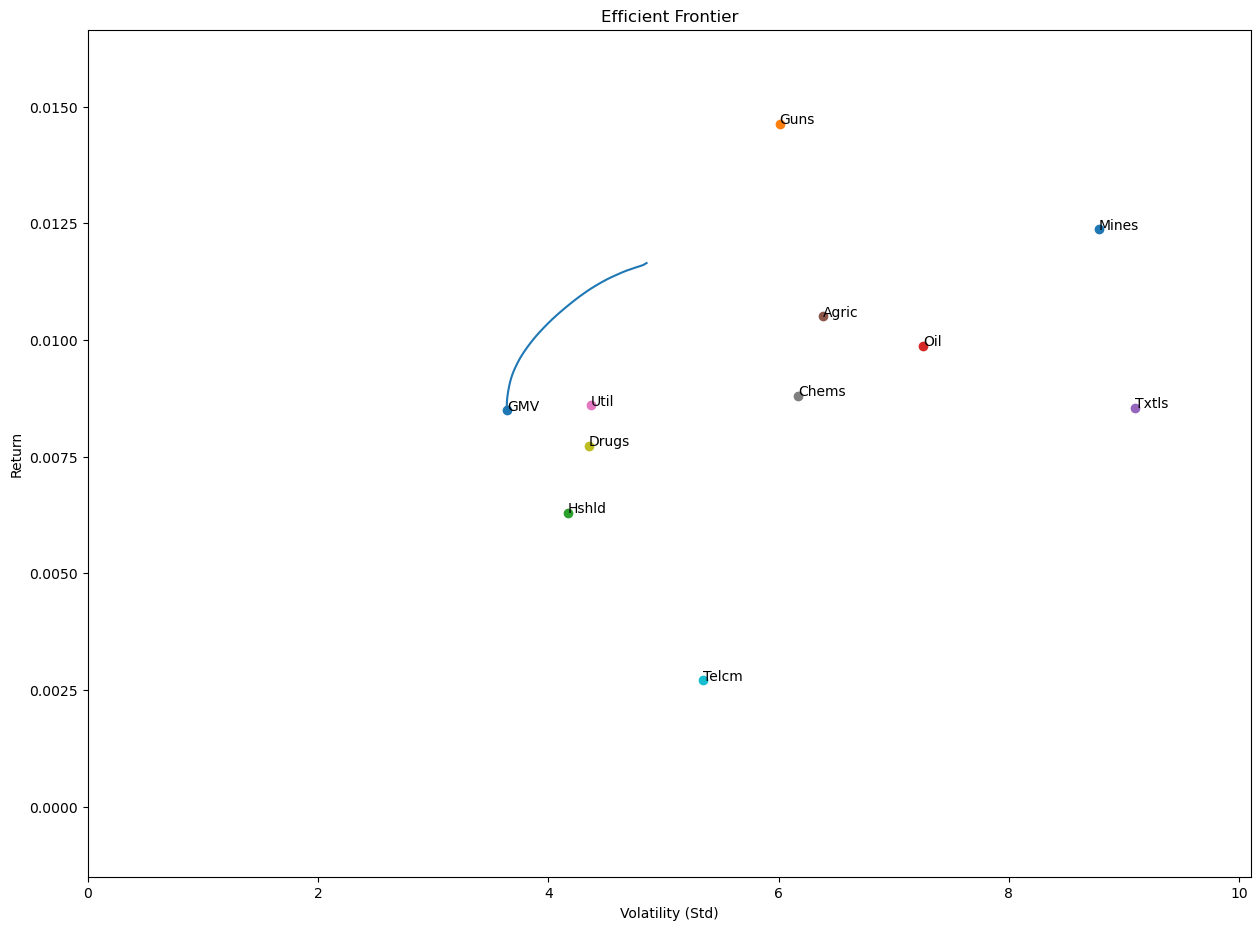

In [64]:
g.plot_Resample_ef_Gurobi(E_return_2, E_cov_2,result1,result2,Expected_Risk_free,show_cml=False, show_gmv=True)


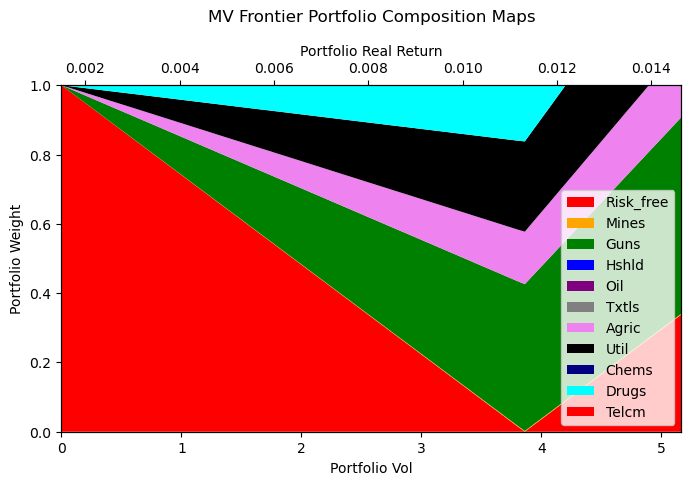

In [65]:
g.transition_map(E_return_2, E_cov_2,Expected_Risk_free, K, Nbr_PTF,bounds = (0,1),no_risk=False)

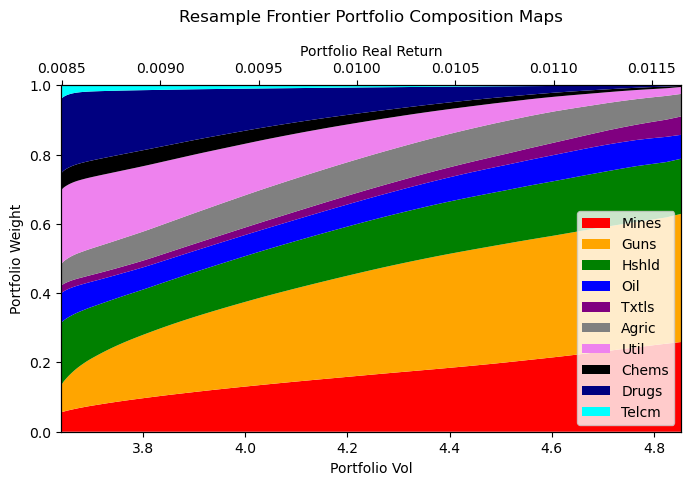

In [66]:
g.Resample_transition_map(result1,bounds = (0,1))

### a-1-g-(e) Graph the mean-variance frontier with risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.¶


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

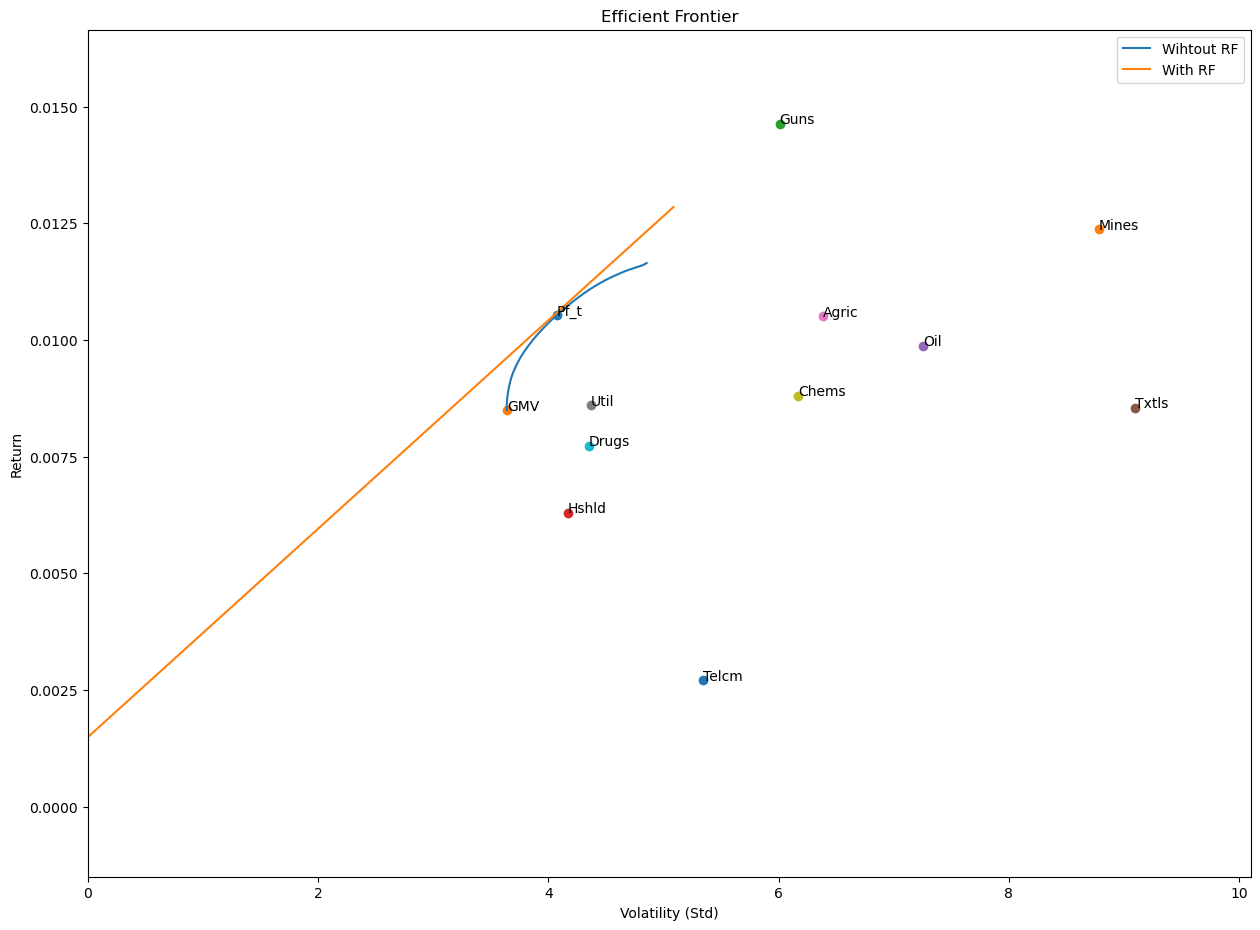

In [67]:
g.plot_Resample_ef_Gurobi(E_return_2, E_cov_2,result1,result2,Expected_Risk_free,show_cml=True, show_gmv=True)

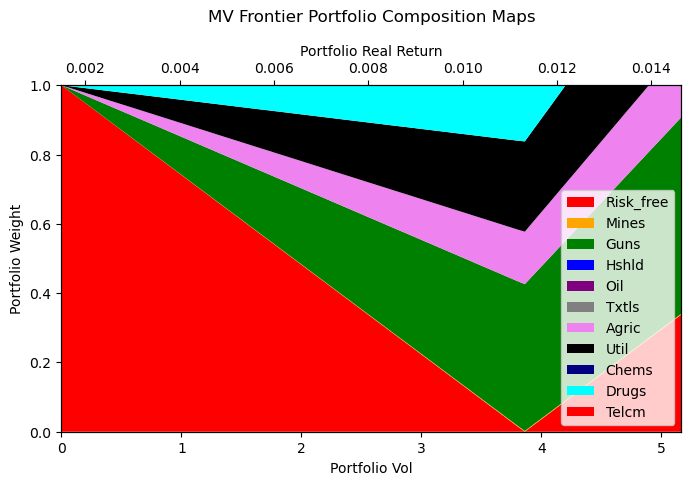

In [68]:
g.transition_map(E_return_2, E_cov_2,Expected_Risk_free, K, Nbr_PTF,bounds = (0,1),no_risk=False)

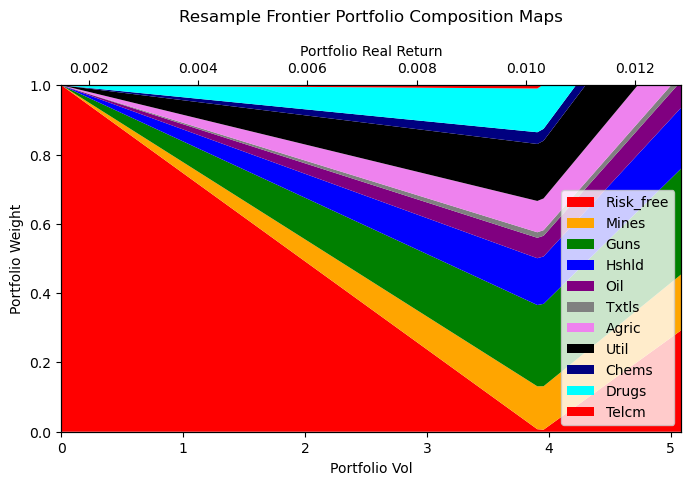

In [69]:
g.Resample_transition_map(result2, bounds = (0,1))

### a-1-g-(f) Can you find a tangent portfolio under short-sale constraints? If so, describe its characteristics such as its mean and variance and the weights of each asset. Explain how the tangent portfolio has changed with the constraint

In [70]:
result = g.tangent_resample(result1,Expected_Risk_free)

result

Mines      Guns     Hshld       Oil     Txtls     Agric      Util  \
64  0.140771  0.262391  0.135284  0.061358  0.022873  0.095159  0.134664   

       Chems     Drugs     Telcm    Return  Volatility    Sharpe  
64  0.034033  0.104726  0.008741  0.010529    4.071208  0.002219

### (a-1-h) The investment policy statement now limits you to invest in up to 3 industry portfolios from the original list of 5 industry portfolios. Repeat the same calculations in (a)-(f) with this additional constraint on the maximum number of assets. Is the optimal combination of assets the same for every target expected return?¶


In [71]:
K=3

### a-1-h-(a) Graph the mean-variance frontier without risk-free asset of the selected 3 industry portfolios. vs 5

In [72]:
result1=g.resample_no_risk(E_return, E_cov_1,Resample1, K, Nbr_PTF,path_regression, bounds = (-2,2))
result2=g.resample_with_risk(E_return, E_cov_1,Resample1,Expected_Risk_free,K, Nbr_PTF,path_regression, bounds = (-2,2))

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

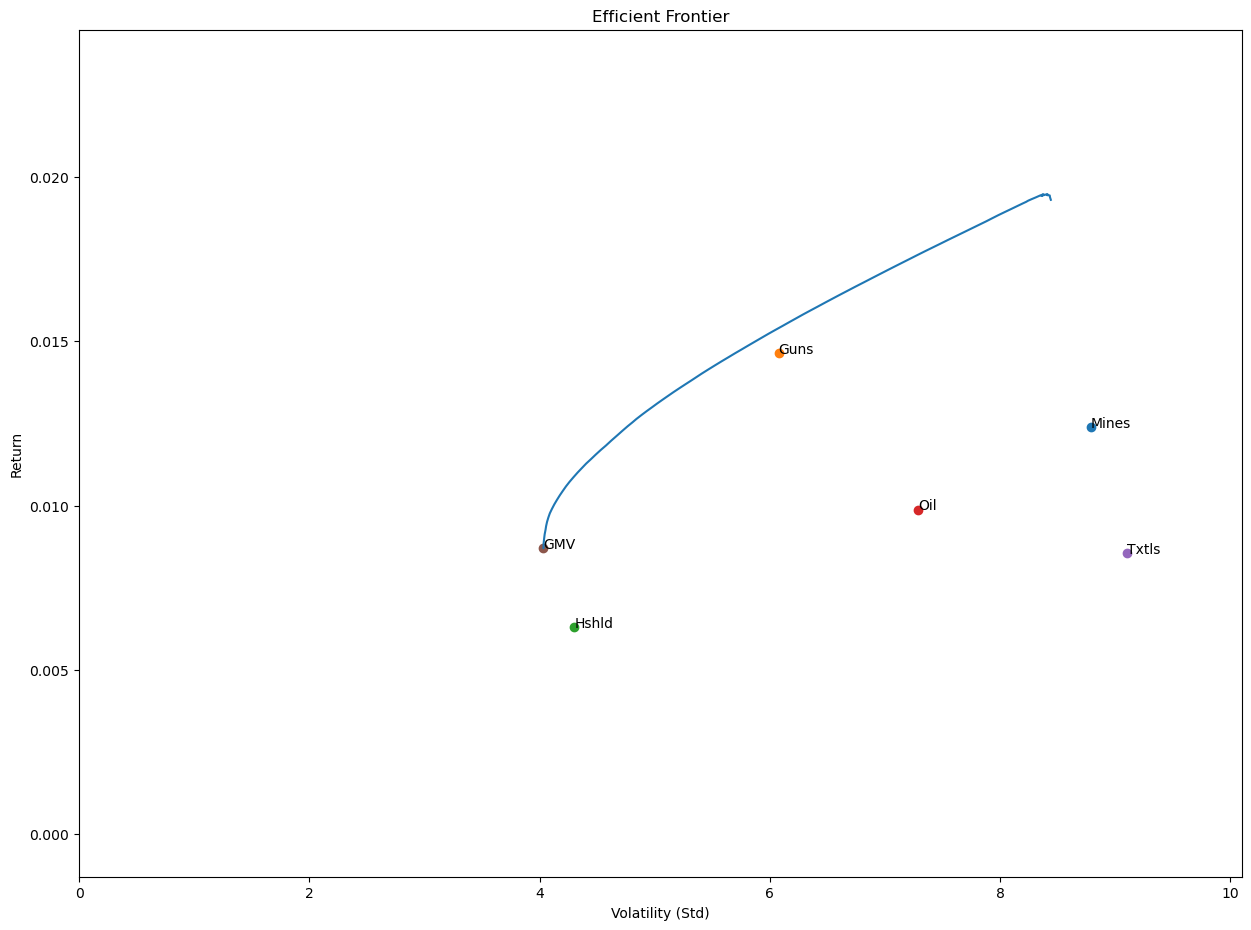

In [73]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=False, show_gmv=True)


### a-1-h-(b) Graph the mean-variance frontier with risk-free asset of the selected 3 industry portfolios. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the introduction of a risk-free asset.¶


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

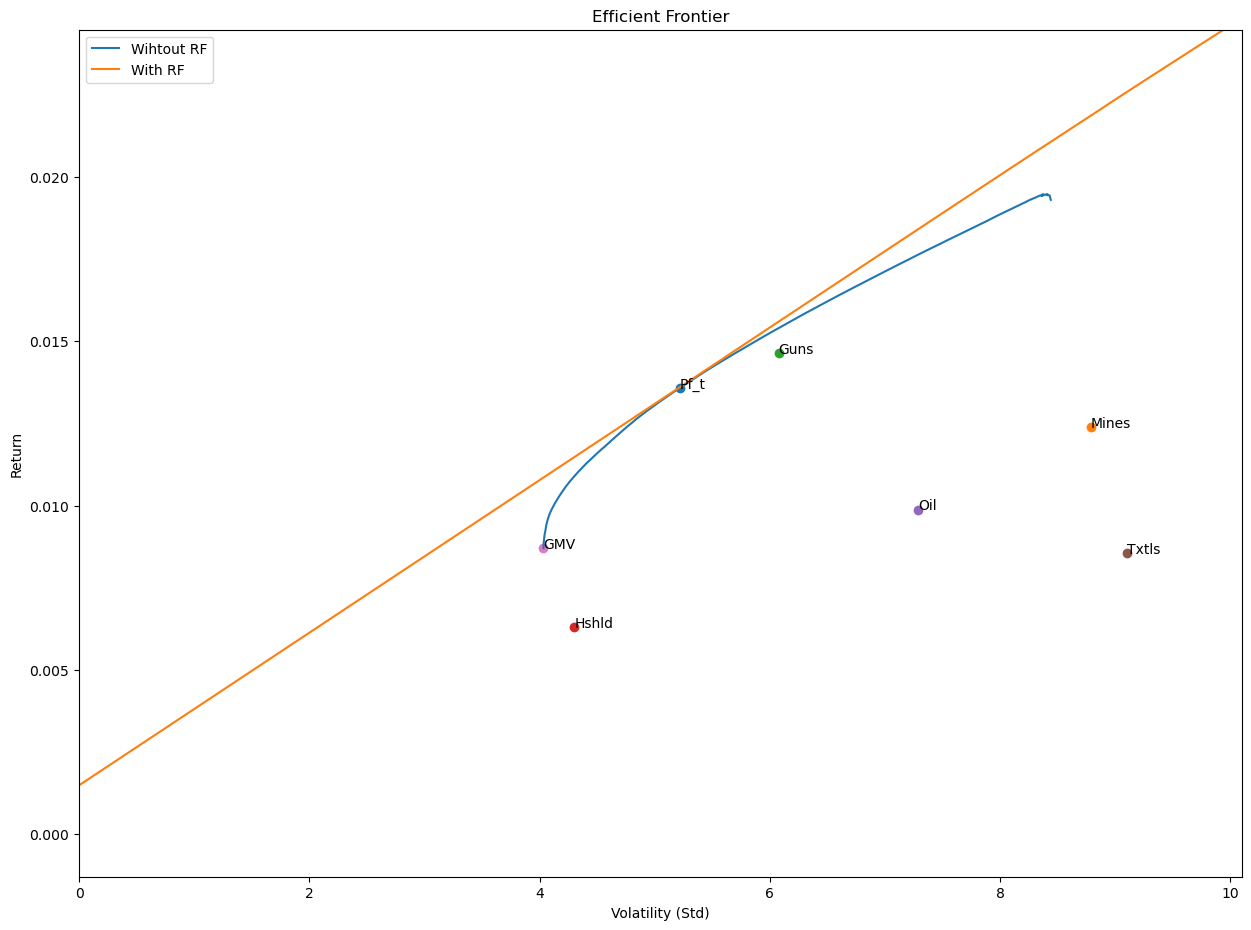

In [74]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=True, show_gmv=True)

### a-1-h-(c) Describe the tangent portfolio and its characteristics such as its mean and variance and the weights of each asset¶


In [75]:
#Trouver portefeuille maximum sharp ratio (Regler probleme de la fonction ou expliquer)
result = g.tangent_resample(result1,Expected_Risk_free)
result


Mines      Guns    Hshld       Oil    Txtls    Return  Volatility  \
37  0.249391  0.707705  0.12207  0.033613 -0.11278  0.013581    5.218406   

      Sharpe  
37  0.002316

### a-1-h-(d) Graph the mean-variance frontier without risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.¶


In [76]:
result1=g.resample_no_risk(E_return, E_cov_1,Resample1, K, Nbr_PTF,path_regression, bounds = (0,1))
result2=g.resample_with_risk(E_return, E_cov_1,Resample1,Expected_Risk_free,K, Nbr_PTF,path_regression, bounds = (0,1))

/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data_return=Data_return.append(Data_return.iloc[-1])
/Users/haroldnonguierma/Desktop/Portfolio-VL/Functions.py:276: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E_return_select = R_T['E_R'].append(E_return_mean)


<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

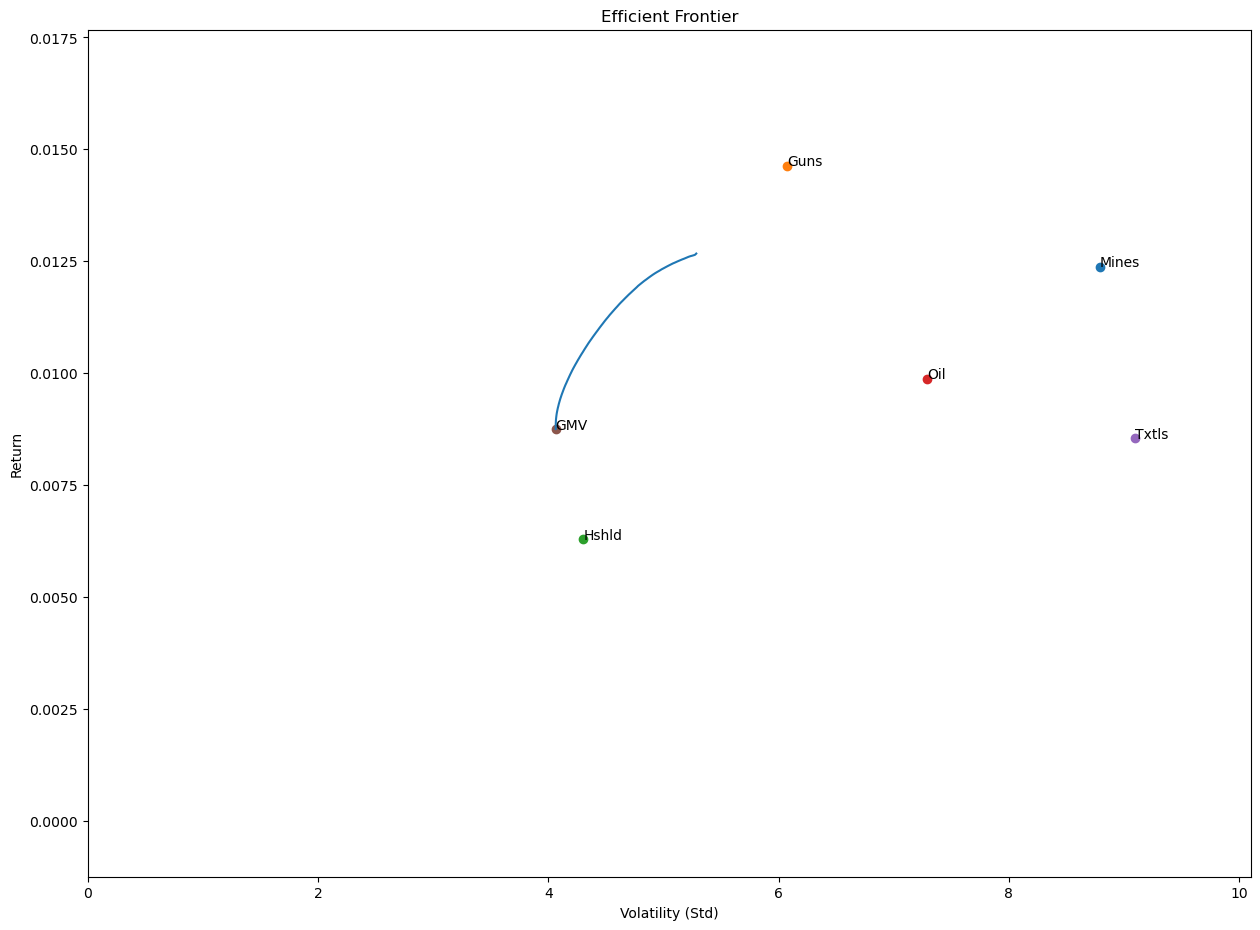

In [77]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=False, show_gmv=True)

### a-1-h-(e) Graph the mean-variance frontier with risk-free asset under short-sale constraints on each industry portfolio. Display each industry portfolio in the chart. Explain how the mean-variance frontier has changed with the constraint.

<AxesSubplot:title={'center':'Efficient Frontier'}, xlabel='Volatility (Std)', ylabel='Return'>

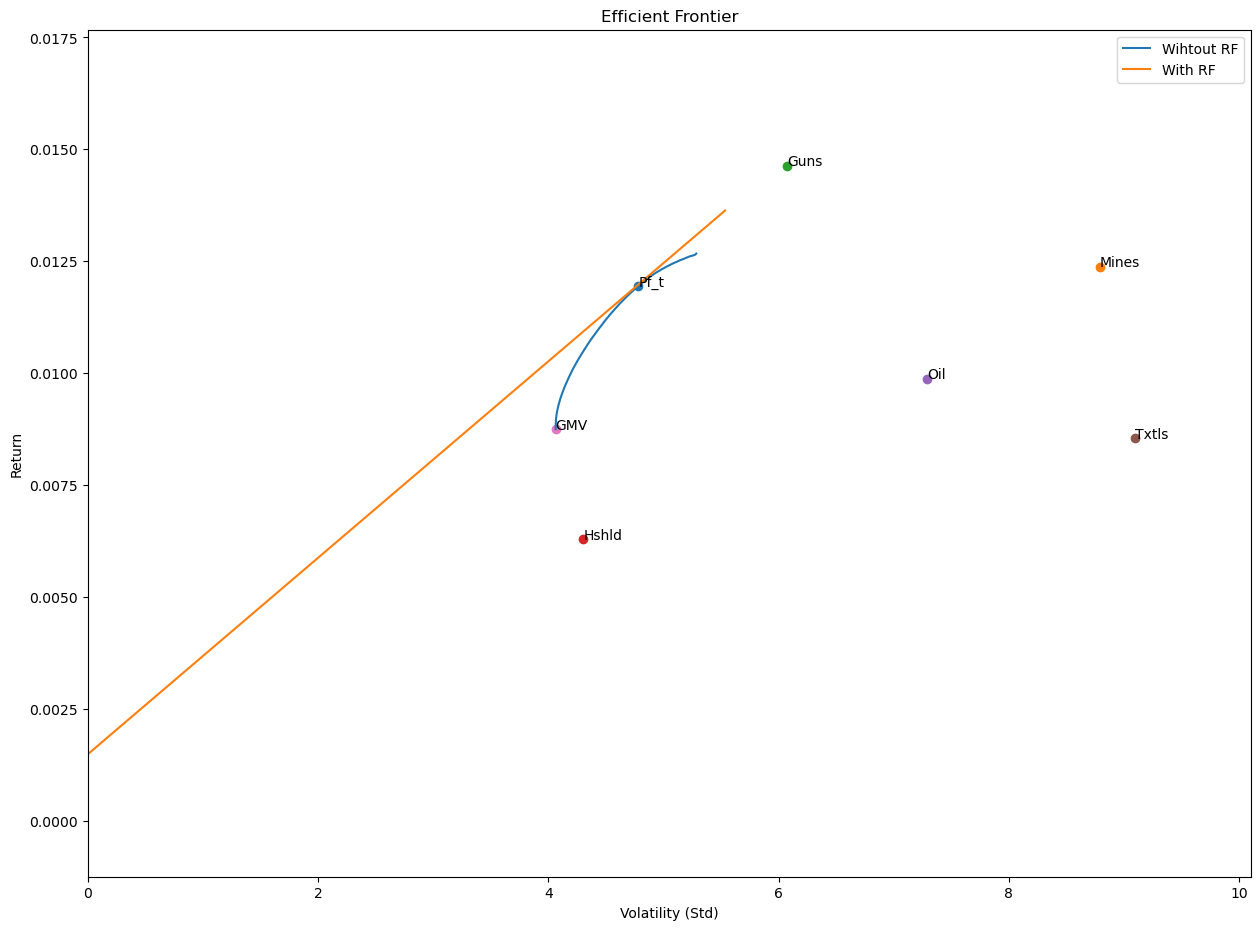

In [78]:
g.plot_Resample_ef_Gurobi(E_return, E_cov_1,result1,result2,Expected_Risk_free,show_cml=True, show_gmv=True)

### a-1-h-(f) Can you find a tangent portfolio under short-sale constraints? If so, describe its characteristics such as its mean and variance and the weights of each asset. Explain how the tangent portfolio has changed with the constraint¶


In [79]:
#Trouver portefeuille maximum sharp ratio
result = g.tangent_resample(result1,Expected_Risk_free)
result


Mines     Guns     Hshld       Oil     Txtls    Return  Volatility  \
71  0.190888  0.49024  0.195828  0.097228  0.025815  0.011952    4.779684   

      Sharpe  
71  0.002188

#### Result presentation : 

#### Determination of the maximum return portfolio (without short sell) :

### (b) Instead of choosing 5 industries randomly as you did in Question 1, find the 5 industries among the 48 industries that maximize the Sharpe ratio with and without short selling constraints. Propose and implement methods to identify industries and their weights.

In [80]:
#Trouver portefeuille maximum sharp ratio
Data_select3 = Data
K=5
E_return_all=E_return_select
E_cov_all=f.Ledoit_wolf(Data_select3)
Resample_all=g.boostrap(Data_select3,Nsim)

In [81]:
#With Short Selling
result = g.tangent_Gurobi(E_return_all,E_cov_all,Expected_Risk_free, K, Nbr_PTF,bounds= (-2,2))
result


Food  Soda  Beer  Smoke  Fun  Books  Clths  Rubbr  BldMt  Cnstr  ...  Oil  \
79   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0    0.0    0.0  ...  0.0   

    Util  Telcm  BusSv  Paper  Boxes  Trans    Return  Volatility    Sharpe  
79   0.0    0.0    0.0    0.0    0.0    0.0  0.173751   12.938033  0.013314  

[1 rows x 51 columns]

In [82]:
#Without Not Short Selling
result = g.tangent_Gurobi(E_return_all,E_cov_all,Expected_Risk_free, K, Nbr_PTF,bounds= (0,1))
result

result


Food  Soda  Beer  Smoke  Fun  Books  Clths  Rubbr  BldMt  Cnstr  ...  Oil  \
75   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0    0.0    0.0  ...  0.0   

      Util  Telcm  BusSv  Paper  Boxes  Trans   Return  Volatility    Sharpe  
75  0.2381    0.0    0.0    0.0    0.0    0.0  0.01295    4.186964  0.002736  

[1 rows x 51 columns]

Look at the excess return per st deviation for combinations of 5 industrie portfolio (To continue)

# À faire : 

- Fonction pour avoir le portefeuille tangente (Fait)
- Plot frontiere efficiente (Sans RF) + avec assets pour visualiser le portefeuille tangente  (Fait)
- Créer une fonction a l'aide matplotlib.pyplot afin de faire de beaux graphes (Fait)
- On pourrait mettre les returns + volatilité annualisées (Fait)
- Répondres aux questions
- Améliorer fonctions pour 3 industries (Fait)



Si on a le temps:
- Trouver une méthodologie pour calculer les Returns des assets (Vincent semblait avoir une méthode)
- Trouver une méthodologie pour calculer la matrice de covariance (À voir)